# Exact Diagonalization of SU(2) spin models:

A simple Python program to diagonalize the Heisenberg model 

In [1]:
import sys
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import scipy.stats as spst
from scipy.linalg import expm
import time

### Visualization functions

In [2]:
def basisVisualizer(L,psi):
    if (psi>=2**L):
        sys.exit('State is bigger than the basis dimension')
    psi_2 = bin(psi)[2:] 
    N  = len(psi_2)
    up = (L-N)*'0'+psi_2
    configStr = "|"
    uparrow   = '\u2191'
    downarrow = '\u2193'
    for i in range(L):
        blank = True
        if up[i] == '1':
            configStr+=uparrow
            blank = False
        if up[i] == '0':
            configStr+=downarrow
            blank = False
        if blank:
            configStr+="_"
        configStr +="|"
    print(configStr)

def countBits(x):
    #From Hacker's Delight, p. 66, counts # 1s in base-10 number x
    x = x - ((x >> 1) & 0x55555555)
    x = (x & 0x33333333) + ((x >> 2) & 0x33333333)
    x = (x + (x >> 4)) & 0x0F0F0F0F
    x = x + (x >> 8)
    x = x + (x >> 16)
    return x & 0x0000003F 

def binp(num, length=4):  # Print binary number without the 0b-format and appropiate number of 0s
    return format(num, '#0{}b'.format(length + 2))[2:]

In [3]:
print("The binary number for |up up down> is:",int('110',2))
print("In binary the state is:",binp(int('110',2),3))
print("The state",int('110',2),"can be visualized as:")
basisVisualizer(L=3,psi=int('110',2))

The binary number for |up up down> is: 6
In binary the state is: 110
The state 6 can be visualized as:
|↑|↑|↓|


### Couplings Distribution

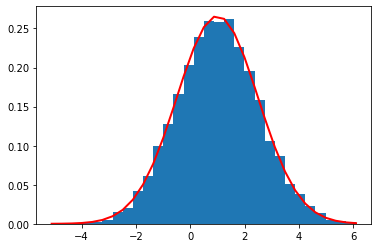

In [4]:
mu, sigma = 1, 1.5 
s = np.random.normal(mu, sigma, 10000)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(bins-mu)**2/(2*sigma**2)),linewidth=2,color='r')
plt.show()

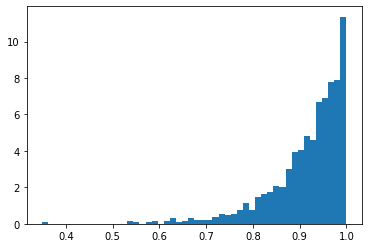

In [5]:
def coupling_power_dist(dis, L):
    J = spst.powerlaw.rvs(dis, size = L)
    aux = np.append(np.ones(L//2), np.ones(L//2)*-1)
    J *= aux
    np.random.shuffle(J)
    return J

a = 10
r = spst.powerlaw.rvs(a, size = 1000)

fig, ax = plt.subplots(1, 1)
ax.hist(r, 50, density=True, histtype='stepfilled', alpha=1)
plt.show()

## Generating the Basis:

We choose, although not efficient pretty straightforward, physical basis $\bigotimes_{i=1}^N\mathbb{C}^2$. It can be in the future to use the tree state basis. 

In [5]:
def makeSzBasis(L):                                # Count bits is O(log(n)) and the loop O(2**L)
    basisSzList = [[] for i in range(0,2*L+1,2)]   # Creates 2L+1's [] for each Sz sector
    for i in range(2**L):
        basisSzList[countBits(i)].append(i)        # Looks # spin up in i, appends it to that sector
    return basisSzList

def printBasis(L):
    SzList = makeSzBasis(L)
    print('====================')
    for i in range(L+1):
        for value in SzList[i]:
            basisVisualizer(L,value)  

In [6]:
makeSzBasis(3)

[[0], [1, 2, 4], [3, 5, 6], [7]]

### Scaling of basis dimension: 

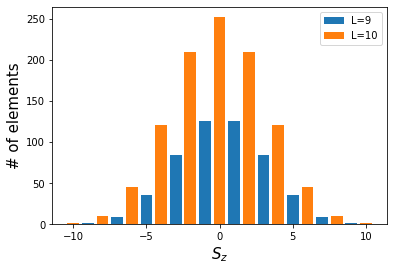

In [7]:
for L in [9,10]:
    basisSzList = makeSzBasis(L)
    SziVals  = []
    sizeVals = []
    for i in range(len(basisSzList)):
        SziVals.append(-L+2*i)
        sizeVals.append(len(basisSzList[i]))
    plt.bar(SziVals,sizeVals,label="L="+str(L))
    
plt.xlabel(r"$S_z$",fontsize=15)
plt.ylabel("# of elements",fontsize=15)
plt.legend()
plt.show()

## Generating the Hamiltonian:

In [8]:
def makeH(SzList,L,Jz,h):    
    basisMap = {}
    stateID  = 0 

    for state in SzList:
        basisMap[state] = stateID
        stateID+=1
        
    nH = stateID                                  # Length of the subspace
    H = np.zeros([nH,nH])                         # Initialize the matrix
    
    for state in SzList:
        idxA = basisMap[state]        
        H[idxA,idxA] += h*(2*countBits(state)-L)/2 
    
        for i in range(L):
            j = (i+1)%L                            # Nearest neighbors, closed chain
            m = (L-j-1)%L
            if (state>>i & 1) == (state>>j & 1):   # Pushes the bits, compares last with 1 and checks if parallel
                H[idxA,idxA] += Jz[m]/4
            else:                                  # If they are not the same, they are antiparallel
                H[idxA,idxA] -= Jz[m]/4
                mask = 2**(i)+2**(j)               # This I'm not sure
                stateB= state^mask                 # Flips the bits at i,j (^ XOR)
                idxB = basisMap[stateB]            # Position of this state
                H[idxA, idxB] += Jz[m]/2
    return H


def SiSj_oper(SzList,L,i,j):
    basisMap = {}
    stateID = 0
    
    for state in SzList: 
        basisMap[state] = stateID
        stateID +=1 
    
    nh = stateID
    mat = np.zeros([nh,nh])
    j = (L-j-1)%L
    i = (L-i-1)%L 
    
    for state in SzList: 
        idxA = basisMap[state]
        if (state>>i & 1) == (state>>j & 1):
            mat[idxA,idxA] += 1/4
        else: 
            mat[idxA,idxA] -= 1/4
            mask = 2**i + 2**j
            stateB = state^mask
            idxB = basisMap[stateB]
            mat[idxA,idxB] += 1/2
    return mat   

## Generating the evolution: 

In [9]:
def gauss_SiSjevol(SiSj,basisSzList,Sz,mean,sigma,realizations,tmin,tmax,N_steps,L):
    dyn_magnon = []
    t_list = np.linspace(tmin,tmax,N_steps)
    Sz = np.abs(Sz)
    
    for i in range(realizations):
        Jz = np.random.normal(mean,sigma,size = L)
        H = makeH(basisSzList,L,Jz,0)
        lam,eigv = np.linalg.eigh(H)
        num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
        num = np.random.randint(num)
        dyn_eigv = eigv[:,num]
        new_state = np.matmul(SiSj, dyn_eigv)
        new_state /= np.linalg.norm(new_state)
        dyn_magnon_values = []
        
        for t in t_list: 
            exp_H = expm(-1.j*H*t)
            ev_state = np.matmul(exp_H,new_state)
            exp_val = np.vdot(new_state, ev_state)
            dyn_magnon_values.append(np.abs(exp_val)**2)
        dyn_magnon.append(dyn_magnon_values)
    
    gauss_mean_dyn = np.mean(dyn_magnon,axis=0)
    gauss_std_dyn = np.std(dyn_magnon,axis=0)

    return gauss_mean_dyn, gauss_std_dyn
    
    
def power_SiSjevol(SiSj,basisSzList,Sz,dis,realizations,tmin,tmax,N_steps,L):
    dyn_magnon = []
    t_list = np.linspace(tmin,tmax,N_steps)
    Sz = np.abs(Sz)
    
    for i in range(realizations):
        Jz = coupling_power_dist(dis,L)
        H = makeH(basisSzList,L,Jz,0)
        lam,eigv = np.linalg.eigh(H)
        num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
        num = np.random.randint(num)
        dyn_eigv = eigv[:,num]
        new_state = np.matmul(SiSj, dyn_eigv)
        new_state /= np.linalg.norm(new_state)
        dyn_magnon_values = []
        
        for t in t_list: 
            exp_H = expm(-1.j*H*t)
            ev_state = np.matmul(exp_H,new_state)
            exp_val = np.vdot(new_state, ev_state)
            dyn_magnon_values.append(np.abs(exp_val)**2)
        dyn_magnon.append(dyn_magnon_values)
    
    power_mean_dyn = np.mean(dyn_magnon,axis=0)
    power_std_dyn = np.std(dyn_magnon,axis=0)

    return power_mean_dyn, power_std_dyn

## Getting the Spectrum:

In [10]:
def getSpectrum(L,Jz,h):
    
    basisSzList  = makeSzBasis(L)
    energies     = []
    lowestEnergy = 1e10
    
    for Szi,SzList in enumerate(basisSzList):
        H     = makeH(SzList,L,Jz,h)
        lam,v = np.linalg.eigh(H)
        energies.append(lam)

        if min(lam) < lowestEnergy:
            lowestEnergy  = min(lam)
            GSSector      = -L/2+Szi
            GSEigenvector = v[:,lam.argmin()]
    
    #print("Energies assembled!")
    #print("Lowest energy:",lowestEnergy)
    #print("The ground state occured in Sz=",GSSector)
    return (lowestEnergy,GSSector,GSEigenvector,energies)

## Generating the Ground State Data & Plots:

In [13]:
# 'Ground state data'
dis_list = [0.1, 0.5, 1, 3]
L_range = np.arange(4,13,2)                      # Go to 14 and save the data
realizations = 100
np.random.seed(12345)

### Gaussian Ground State Data:

For $L=14$, each disorder realization loop takes around ~$25$s, meaning that in total it takes around $3$ hours to run the whole $100$ realizations times the $4$ disorders. 

For $L=16$, each disorder realization loop takes around ~$1010$s meaning that in total it takes around 4 days to run the whole $100$ realizations times the $4$ disorders.

In [12]:
# Ferromagnetic Ground State Gaussian Lists: 
FGS_mean_energy_list = []
FGS_std_energy_list = []
mean = -1

for dis in dis_list:
    FGS_mean_energy_dis = []
    FGS_std_energy_dis = []
    for L in L_range:
        FGS_energy_list = []
        tic = time.perf_counter()
        for i in range(realizations):
            #tic1 = time.perf_counter()
            J = np.random.normal(mean,dis,size=L)
            lowestEnergy,GSSector,GSEigenvector,energies=getSpectrum(L,J,0)
            FGS_energy_list.append(lowestEnergy)
            #toc1 = time.perf_counter()
            #print('Time to finish one loop {}'.format(toc1-tic1))
        mean_energy = np.mean(FGS_energy_list)
        std_energy = np.std(FGS_energy_list)
        FGS_mean_energy_dis.append(mean_energy)
        FGS_std_energy_dis.append(std_energy)
        toc = time.perf_counter()
        print('Time to finish for L = {}: {}'.format(L,toc-tic))
    print('=============================================================================')
    FGS_mean_energy_list.append(FGS_mean_energy_dis)
    FGS_std_energy_list.append(FGS_std_energy_dis)

Time to finish for L = 4: 0.06113496499995108
Time to finish for L = 6: 0.2178006890000006
Time to finish for L = 8: 1.0819347060000837
Time to finish for L = 10: 6.281384068999955
Time to finish for L = 12: 87.84632254299993
Time to finish for L = 4: 0.05628388700006326
Time to finish for L = 6: 0.286880993000068
Time to finish for L = 8: 1.3990060649999805
Time to finish for L = 10: 8.115772912000011
Time to finish for L = 12: 91.48549029699996
Time to finish for L = 4: 0.05964647399991918
Time to finish for L = 6: 0.2755013810000264
Time to finish for L = 8: 1.4411388680000528
Time to finish for L = 10: 8.151999443000022
Time to finish for L = 12: 80.32825284500007
Time to finish for L = 4: 0.06120461000000432
Time to finish for L = 6: 0.3066225210000084
Time to finish for L = 8: 1.4527159799999936
Time to finish for L = 10: 8.7205703059999
Time to finish for L = 12: 83.06915412700005


In [13]:
# Anti-Ferromagnetic Ground State Gaussian Lists: 
AGS_mean_energy_list = []
AGS_std_energy_list = []
mean = 1

for dis in dis_list:
    AGS_mean_energy_dis = []
    AGS_std_energy_dis = []
    for L in L_range:
        AGS_energy_list = []
        tic = time.perf_counter()
        for i in range(realizations):
            #tic1 = time.perf_counter()
            J = np.random.normal(mean,dis,size=L)
            lowestEnergy,GSSector,GSEigenvector,energies=getSpectrum(L,J,0)
            AGS_energy_list.append(lowestEnergy)
            #toc1 = time.perf_counter()
            #print('Time to finish one loop {}'.format(toc1-tic1))
        mean_energy = np.mean(AGS_energy_list)
        std_energy = np.std(AGS_energy_list)
        AGS_mean_energy_dis.append(mean_energy)
        AGS_std_energy_dis.append(std_energy)
        toc = time.perf_counter()
        print('Time to finish for L = {}: {}'.format(L,toc-tic))
    print('=============================================================================')
    AGS_mean_energy_list.append(AGS_mean_energy_dis)
    AGS_std_energy_list.append(AGS_std_energy_dis)

Time to finish for L = 4: 0.07109616999991886
Time to finish for L = 6: 0.34614915599991036
Time to finish for L = 8: 1.5229062109999632
Time to finish for L = 10: 10.22645733399986
Time to finish for L = 12: 88.92925333199992
Time to finish for L = 4: 0.07036048000009032
Time to finish for L = 6: 0.33562373099994147
Time to finish for L = 8: 1.6999239849999412
Time to finish for L = 10: 9.930602976000046
Time to finish for L = 12: 96.89523701799999
Time to finish for L = 4: 0.06853047200002038
Time to finish for L = 6: 0.30860645799998565
Time to finish for L = 8: 1.6649483470000632
Time to finish for L = 10: 9.512798906000171
Time to finish for L = 12: 92.22111916199992
Time to finish for L = 4: 0.06488241300007758
Time to finish for L = 6: 0.35471063199997843
Time to finish for L = 8: 1.7659115060000659
Time to finish for L = 10: 9.810923202999902
Time to finish for L = 12: 92.28946358600001


### Power-law Ground State Data:

In [14]:
# Ground State Power-law Lists: 
GSP_mean_energy_list = []
GSP_std_energy_list = []

for dis in dis_list:
    GSP_mean_energy_dis = []
    GSP_std_energy_dis = []
    for L in L_range:
        GSP_energy_list = []
        tic = time.perf_counter()
        for i in range(realizations):
            #tic1 = time.perf_counter()
            J = coupling_power_dist(dis,L)
            lowestEnergy,GSSector,GSEigenvector,energies=getSpectrum(L,J,0)
            GSP_energy_list.append(lowestEnergy)
            #toc1 = time.perf_counter()
            #print('Time to finish one loop {}'.format(toc1-tic1))
        mean_energy = np.mean(GSP_energy_list)
        std_energy = np.std(GSP_energy_list)
        GSP_mean_energy_dis.append(mean_energy)
        GSP_std_energy_dis.append(std_energy)
        toc = time.perf_counter()
        print('Time to finish for L = {}: {}'.format(L,toc-tic))
    print('=============================================================================')
    GSP_mean_energy_list.append(GSP_mean_energy_dis)
    GSP_std_energy_list.append(GSP_std_energy_dis)

Time to finish for L = 4: 0.09185932800005503
Time to finish for L = 6: 0.3554717189999792
Time to finish for L = 8: 1.6894311959999868
Time to finish for L = 10: 9.953620332000128
Time to finish for L = 12: 89.61211787000002
Time to finish for L = 4: 0.0810568780000267
Time to finish for L = 6: 0.3063702209999519
Time to finish for L = 8: 1.5087636119999388
Time to finish for L = 10: 8.396416085000055
Time to finish for L = 12: 80.91203715699999
Time to finish for L = 4: 0.08305272699999477
Time to finish for L = 6: 0.3148975159999736
Time to finish for L = 8: 1.539984719999893
Time to finish for L = 10: 8.8329738299999
Time to finish for L = 12: 90.07206810299999
Time to finish for L = 4: 0.08152367299999241
Time to finish for L = 6: 0.32963869100012744
Time to finish for L = 8: 1.746311936000211
Time to finish for L = 10: 10.561925414999905
Time to finish for L = 12: 81.48098630499999


## Generating the Plots:

### Ground State Plots:

In [15]:
# Some list cleaning
FGS_L = FGS_mean_energy_list/L_range
FGS_E = np.array(FGS_std_energy_list)/(L_range*np.sqrt(realizations))
AGS_L = AGS_mean_energy_list/L_range
AGS_E = np.array(AGS_std_energy_list)/(L_range*np.sqrt(realizations))
GSP_L = GSP_mean_energy_list/L_range
GSP_E = np.array(GSP_std_energy_list)/(L_range*np.sqrt(realizations))
x = np.linspace(0,1/L_range[0],100)

FGSlope_m = []
FGInter_b = []
AGSlope_m = []
AGInter_b = []
PLSlope_m = []
PLInter_b = []
linear_fit = []
num = 3

for i in range(len(FGS_L)):
    m , b = np.polyfit(1/L_range[-num:],FGS_L[i][-num:], deg=1, w = 1/FGS_E[i][-num:])
    FGSlope_m.append(m)
    FGInter_b.append(b)
    linear_fit.append(m*x+b)
    m , b = np.polyfit(1/L_range[-num:],AGS_L[i][-num:], deg=1, w = 1/AGS_E[i][-num:])
    AGSlope_m.append(m)
    AGInter_b.append(b)
    linear_fit.append(m*x+b)
    m , b = np.polyfit(1/L_range[-num:],GSP_L[i][-num:], deg=1, w = 1/GSP_E[i][-num:])
    PLSlope_m.append(m)
    PLInter_b.append(b)
    linear_fit.append(m*x+b)

### Ferromagnetic Gaussian Ground State

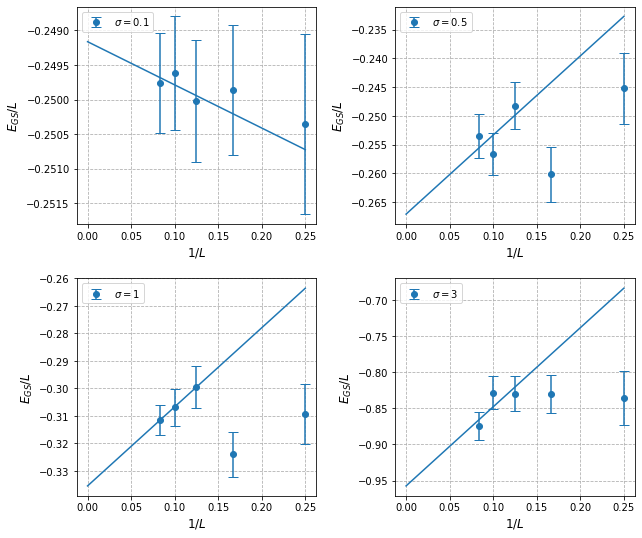

In [19]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2,figsize = (10,9))
plt.subplots_adjust(wspace=0.33, hspace=0.25)

ax1.errorbar(1/L_range,FGS_L[0], FGS_E[0], fmt = 'o', capsize = 5, label = r'$\sigma =$'+str(dis_list[0]))
ax2.errorbar(1/L_range,FGS_L[1], FGS_E[1], fmt = 'o', capsize = 5, label = r'$\sigma =$'+str(dis_list[1]) )
ax3.errorbar(1/L_range,FGS_L[2], FGS_E[2], fmt = 'o', capsize = 5, label = r'$\sigma =$'+str(dis_list[2]) )
ax4.errorbar(1/L_range,FGS_L[3], FGS_E[3], fmt = 'o', capsize = 5, label = r'$\sigma =$'+str(dis_list[3]) )

ax1.plot(x, linear_fit[0],color ='tab:blue')
ax2.plot(x,linear_fit[3],color ='tab:blue')
ax3.plot(x,linear_fit[6],color ='tab:blue')
ax4.plot(x,linear_fit[9],color ='tab:blue')

ax1.set_xlabel('$1/L$', fontsize=12)
ax1.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax1.grid(True, ls='dashed')
ax1.legend(loc = 'upper left')

ax2.set_xlabel('$1/L$', fontsize=12)
ax2.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax2.grid(True, ls='dashed')
ax2.legend(loc = 'upper left')

ax3.set_xlabel('$1/L$', fontsize=12)
ax3.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax3.grid(True, ls='dashed')
ax3.legend(loc = 'upper left')

ax4.set_xlabel('$1/L$', fontsize=12)
ax4.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax4.grid(True, ls='dashed')
ax4.legend(loc = 'upper left')

plt.savefig('Disorder_Ground_Energy_2.pdf',  bbox_inches='tight', dpi=300)
plt.show()

### Anti-Ferromagnetic Gaussian Ground State

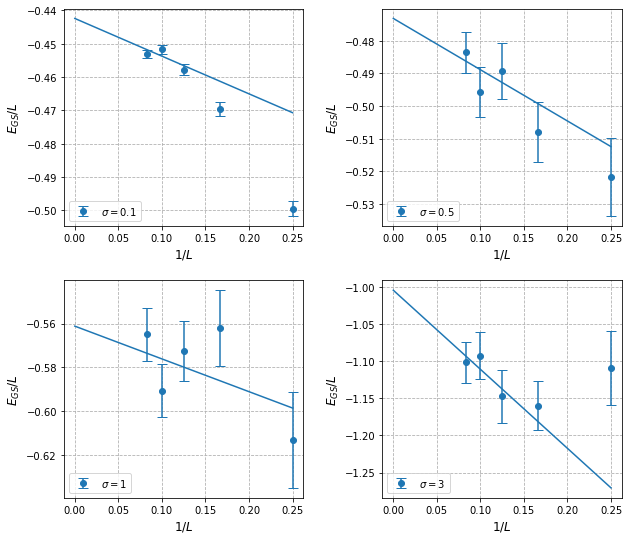

In [21]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2,figsize = (10,9))
plt.subplots_adjust(wspace=0.33, hspace=0.25)

ax1.errorbar(1/L_range,AGS_L[0], AGS_E[0], fmt = 'o', capsize = 5, label = r'$\sigma =$'+str(dis_list[0]))
ax2.errorbar(1/L_range,AGS_L[1], AGS_E[1], fmt = 'o', capsize = 5, label = r'$\sigma =$'+str(dis_list[1]) )
ax3.errorbar(1/L_range,AGS_L[2], AGS_E[2], fmt = 'o', capsize = 5, label = r'$\sigma =$'+str(dis_list[2]) )
ax4.errorbar(1/L_range,AGS_L[3], AGS_E[3], fmt = 'o', capsize = 5, label = r'$\sigma =$'+str(dis_list[3]) )

ax1.plot(x, linear_fit[1],color ='tab:blue')
ax2.plot(x,linear_fit[4],color ='tab:blue')
ax3.plot(x,linear_fit[7],color ='tab:blue')
ax4.plot(x,linear_fit[10],color ='tab:blue')

ax1.set_xlabel('$1/L$', fontsize=12)
ax1.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax1.grid(True, ls='dashed')
ax1.legend(loc = 'lower left')

ax2.set_xlabel('$1/L$', fontsize=12)
ax2.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax2.grid(True, ls='dashed')
ax2.legend(loc = 'lower left')

ax3.set_xlabel('$1/L$', fontsize=12)
ax3.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax3.grid(True, ls='dashed')
ax3.legend(loc = 'lower left')

ax4.set_xlabel('$1/L$', fontsize=12)
ax4.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax4.grid(True, ls='dashed')
ax4.legend(loc = 'lower left')

plt.savefig('Disorder_AFMGround_Energy_2.pdf',  bbox_inches='tight', dpi=300)
plt.show()

### Power-Law Ground State: 

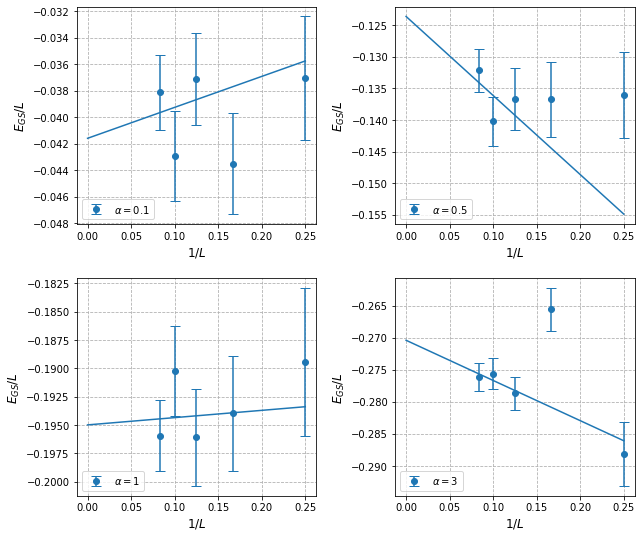

In [22]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2,figsize = (10,9))
plt.subplots_adjust(wspace=0.33, hspace=0.25)

ax1.errorbar(1/L_range,GSP_L[0], GSP_E[0], fmt = 'o', capsize = 5, label = r'$\alpha =$'+str(dis_list[0]))
ax2.errorbar(1/L_range,GSP_L[1], GSP_E[1], fmt = 'o', capsize = 5, label = r'$\alpha =$'+str(dis_list[1]) )
ax3.errorbar(1/L_range,GSP_L[2], GSP_E[2], fmt = 'o', capsize = 5, label = r'$\alpha =$'+str(dis_list[2]) )
ax4.errorbar(1/L_range,GSP_L[3], GSP_E[3], fmt = 'o', capsize = 5, label = r'$\alpha =$'+str(dis_list[3]) )

ax1.plot(x, linear_fit[2],color ='tab:blue')
ax2.plot(x,linear_fit[5],color ='tab:blue')
ax3.plot(x,linear_fit[8],color ='tab:blue')
ax4.plot(x,linear_fit[11],color ='tab:blue')

ax1.set_xlabel('$1/L$', fontsize=12)
ax1.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax1.grid(True, ls='dashed')
ax1.legend(loc = 'lower left')

ax2.set_xlabel('$1/L$', fontsize=12)
ax2.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax2.grid(True, ls='dashed')
ax2.legend(loc = 'lower left')

ax3.set_xlabel('$1/L$', fontsize=12)
ax3.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax3.grid(True, ls='dashed')
ax3.legend(loc = 'lower left')

ax4.set_xlabel('$1/L$', fontsize=12)
ax4.set_ylabel(r'$E_{GS}/L$', fontsize=12)
ax4.grid(True, ls='dashed')
ax4.legend(loc = 'lower left')

plt.savefig('Disorder_Ground_Energy_power.pdf',  bbox_inches='tight', dpi=300)
plt.show()

### Power-Law Fitting

In [61]:
GSP_log_E = GSP_E/(10*GSP_L)

In [62]:
GSP_log_E

array([[-0.01262622, -0.00876987, -0.00938179, -0.00789618, -0.00736565],
       [-0.00496662, -0.00433065, -0.00355918, -0.00277914, -0.00257441],
       [-0.00344571, -0.00262401, -0.00218901, -0.00210286, -0.00159609],
       [-0.00173297, -0.00124567, -0.00091236, -0.00088397, -0.00077714]])

## Generating the Dynamics Data & Plots:

In [78]:
# 'Dynamics Data'
L = 26
mean = 1
Sz = -L/2 + 1
sector = 1                                    
t_max = 30
N_steps = 100
realizations=1000
t_list = np.linspace(0,t_max,N_steps)
basisSzList = makeSzBasis(L)[sector]
SiSj = SiSj_oper(basisSzList,L,0,1)

### Gaussian Evolution Data

In [31]:
# Gaussian Dynamics Lists:
GD_magnon_dis = [] 
GD_std_dis = []
#realizations = 10
tic = time.perf_counter()
for sigma in dis_list:
    dyn_magnon, dyn_std = gauss_SiSjevol(SiSj,basisSzList,Sz,mean,sigma,realizations,0,t_max,N_steps,L)
    GD_magnon_dis.append(dyn_magnon)
    GD_std_dis.append(dyn_std)
    toc = time.perf_counter()
    print('Time to finish for L = {}: {}'.format(L,toc-tic))

Time to finish for L = 26: 156.10297247000562
Time to finish for L = 26: 295.75848099299765
Time to finish for L = 26: 438.16749485400214
Time to finish for L = 26: 618.0394176109985


### Power-Law Evolution Data

In [79]:
# Power-Law Dynamics Lists:
PLD_magnon_dis = []
PLD_std_dis = []

for dis in dis_list:
    tic = time.perf_counter()
    dyn_magnon, dyn_std = power_SiSjevol(SiSj,basisSzList,Sz,dis,realizations,0,t_max,N_steps,L)
    PLD_magnon_dis.append(dyn_magnon)
    PLD_std_dis.append(dyn_std)
    toc = time.perf_counter()
    print('Time to finish for L = {}: {}'.format(L,toc-tic))

Time to finish for L = 26: 130.07657362999817
Time to finish for L = 26: 152.89478922299895
Time to finish for L = 26: 150.81463962199996
Time to finish for L = 26: 147.80576343600114


### Gaussian Dynamics

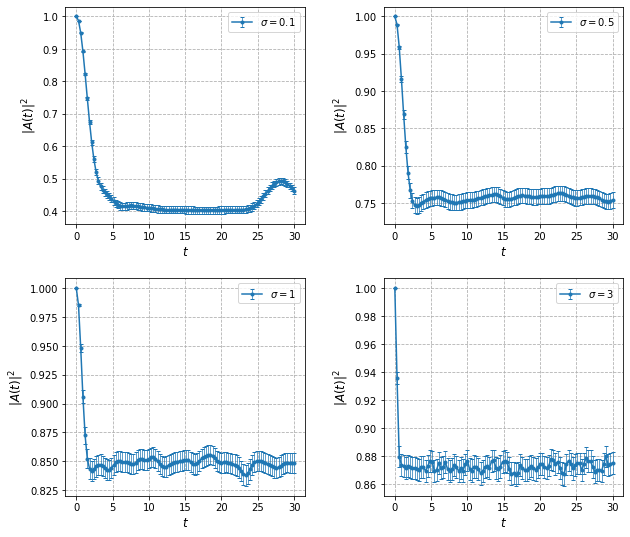

In [33]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2,figsize = (10,9))
plt.subplots_adjust(wspace=0.33, hspace=0.25)

ax1.errorbar(t_list,GD_magnon_dis[0], GD_std_dis[0]/np.sqrt(realizations), marker = '.', elinewidth =0.7, ms = 6,capsize = 2, label = r'$\sigma =$'+str(dis_list[0]))
ax2.errorbar(t_list,GD_magnon_dis[1], GD_std_dis[1]/np.sqrt(realizations), marker = '.', elinewidth =0.7, ms=6,capsize = 2, label = r'$\sigma =$'+str(dis_list[1]) )
ax3.errorbar(t_list,GD_magnon_dis[2], GD_std_dis[2]/np.sqrt(realizations), marker = '.', elinewidth = 0.7, ms=6,capsize = 2, label = r'$\sigma =$'+str(dis_list[2]) )
ax4.errorbar(t_list,GD_magnon_dis[3], GD_std_dis[3]/np.sqrt(realizations), marker = '.', elinewidth=0.7, markersize = 6, capsize = 2, label = r'$\sigma =$'+str(dis_list[3]) )

ax1.set_xlabel('$t$', fontsize=12)
ax1.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax1.grid(True, ls='dashed')
ax1.legend(loc = 'upper right')

ax2.set_xlabel('$t$', fontsize=12)
ax2.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax2.grid(True, ls='dashed')
ax2.legend(loc = 'upper right')

ax3.set_xlabel('$t$', fontsize=12)
ax3.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax3.grid(True, ls='dashed')
ax3.legend(loc = 'upper right')

ax4.set_xlabel('$t$', fontsize=12)
ax4.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax4.grid(True, ls='dashed')
ax4.legend(loc = 'upper right')

plt.savefig('Dynamics_Gauss_L26.pdf',  bbox_inches='tight', dpi=300)
plt.show()

### Power-Law Dynamics

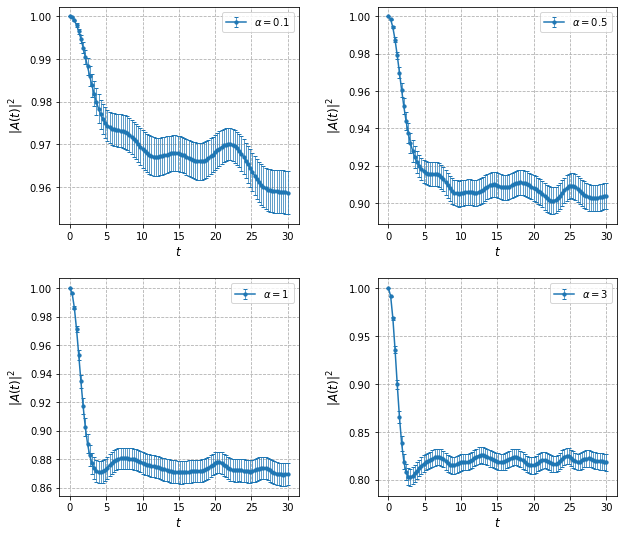

In [81]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2,figsize = (10,9))
plt.subplots_adjust(wspace=0.33, hspace=0.25)

ax1.errorbar(t_list,PLD_magnon_dis[0], PLD_std_dis[0]/np.sqrt(realizations), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\alpha =$'+str(dis_list[0]))
ax2.errorbar(t_list,PLD_magnon_dis[1], PLD_std_dis[1]/np.sqrt(realizations), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\alpha =$'+str(dis_list[1]) )
ax3.errorbar(t_list,PLD_magnon_dis[2], PLD_std_dis[2]/np.sqrt(realizations), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\alpha =$'+str(dis_list[2]) )
ax4.errorbar(t_list,PLD_magnon_dis[3], PLD_std_dis[3]/np.sqrt(realizations), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\alpha =$'+str(dis_list[3]) )

ax1.set_xlabel('$t$', fontsize=12)
ax1.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax1.grid(True, ls='dashed')
ax1.legend(loc = 'upper right')

ax2.set_xlabel('$t$', fontsize=12)
ax2.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax2.grid(True, ls='dashed')
ax2.legend(loc = 'upper right')

ax3.set_xlabel('$t$', fontsize=12)
ax3.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax3.grid(True, ls='dashed')
ax3.legend(loc = 'upper right')

ax4.set_xlabel('$t$', fontsize=12)
ax4.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax4.grid(True, ls='dashed')
ax4.legend(loc = 'upper right')

plt.savefig('Dynamics_Power_L26.pdf',  bbox_inches='tight', dpi=300)
plt.show()

### Asymptotic Dynamics

In [28]:
# Gaussian Dynamics Lists: 10 minutos
GD_magnon_dis2 = [] 
GD_std_dis2 = []
t_min = 2000
t_max = 2100
realizations = 100
t_list = np.linspace(t_min,t_max,N_steps)
for sigma in dis_list:
    dyn_magnon, dyn_std = gauss_SiSjevol(SiSj,basisSzList,Sz,mean,sigma,realizations,t_min,t_max,N_steps,L)
    GD_magnon_dis2.append(dyn_magnon)
    GD_std_dis2.append(dyn_std)

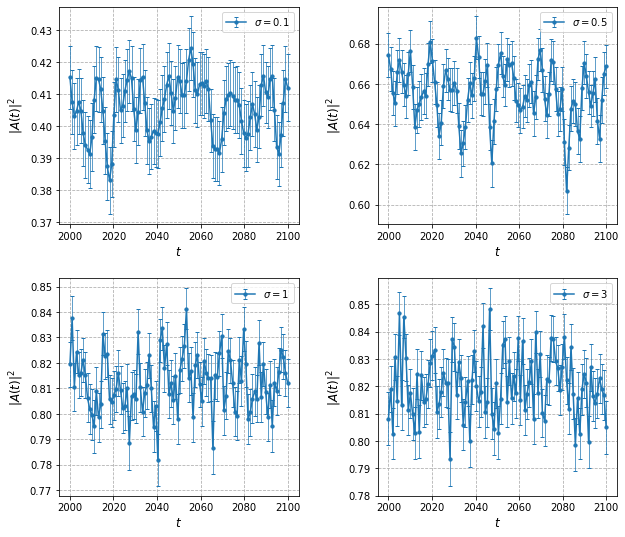

In [29]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2,figsize = (10,9))
plt.subplots_adjust(wspace=0.33, hspace=0.25)

ax1.errorbar(t_list,GD_magnon_dis2[0], GD_std_dis2[0]/np.sqrt(1000), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\sigma =$'+str(dis_list[0]))
ax2.errorbar(t_list,GD_magnon_dis2[1], GD_std_dis2[1]/np.sqrt(1000), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\sigma =$'+str(dis_list[1]) )
ax3.errorbar(t_list,GD_magnon_dis2[2], GD_std_dis2[2]/np.sqrt(1000), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\sigma =$'+str(dis_list[2]) )
ax4.errorbar(t_list,GD_magnon_dis2[3], GD_std_dis2[3]/np.sqrt(1000), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\sigma =$'+str(dis_list[3]) )

ax1.set_xlabel('$t$', fontsize=12)
ax1.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax1.grid(True, ls='dashed')
ax1.legend(loc = 'upper right')

ax2.set_xlabel('$t$', fontsize=12)
ax2.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax2.grid(True, ls='dashed')
ax2.legend(loc = 'upper right')

ax3.set_xlabel('$t$', fontsize=12)
ax3.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax3.grid(True, ls='dashed')
ax3.legend(loc = 'upper right')

ax4.set_xlabel('$t$', fontsize=12)
ax4.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax4.grid(True, ls='dashed')
ax4.legend(loc = 'upper right')

plt.savefig('Asympt_Dynamics_Gauss_L16.pdf',  bbox_inches='tight', dpi=300)
plt.show()

In [30]:
GD_magnon_dis2 = [] 
GD_std_dis2 = []
t_min = 2000
t_max = 2100
realizations = 100
t_list = np.linspace(t_min,t_max,N_steps)
for sigma in np.linspace(0.1,2,8):
    dyn_magnon, dyn_std = gauss_SiSjevol(SiSj,basisSzList,Sz,mean,sigma,realizations,t_min,t_max,N_steps,L)
    GD_magnon_dis2.append(dyn_magnon)
    GD_std_dis2.append(dyn_std)

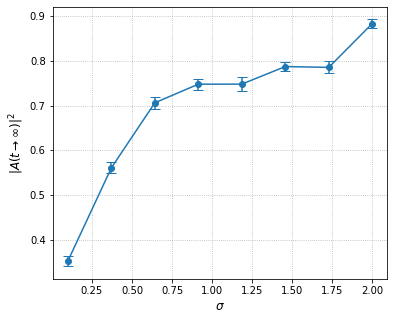

In [31]:
GD_sigma = np.mean(GD_magnon_dis2,axis=1)
GD_E = np.std(GD_magnon_dis2,axis=1)
sigma_list = np.linspace(0.1,2,8)

fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(sigma_list, GD_sigma, GD_E, marker = 'o', capsize= 5)
ax.set_xlabel(r'$\sigma$', fontsize=12)
ax.set_ylabel(r'$ |A(t\rightarrow \infty)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
#ax.legend(loc='upper right', prop={'size': 10})

plt.savefig('Asympt_Dynamics_Gauss_sigma.pdf',  bbox_inches='tight', dpi=300)
plt.show()

In [35]:
# Power-Law Dynamics Lists:
PLD_magnon_dis2 = []
PLD_std_dis2 = []
t_min = 3000
t_max = 3100
realizations = 100
t_list = np.linspace(t_min,t_max,N_steps)

for dis in np.linspace(0.1,2,8):
    dyn_magnon, dyn_std = power_SiSjevol(SiSj,basisSzList,Sz,dis,realizations,t_min,t_max,N_steps,L)
    PLD_magnon_dis2.append(dyn_magnon)
    PLD_std_dis2.append(dyn_std)

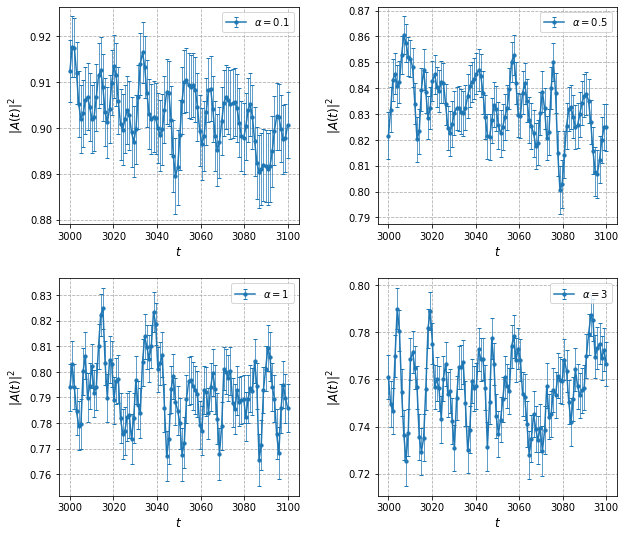

In [36]:
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2,figsize = (10,9))
plt.subplots_adjust(wspace=0.33, hspace=0.25)

ax1.errorbar(t_list,PLD_magnon_dis2[0], PLD_std_dis2[0]/np.sqrt(1000), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\alpha =$'+str(dis_list[0]))
ax2.errorbar(t_list,PLD_magnon_dis2[1], PLD_std_dis2[1]/np.sqrt(1000),marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\alpha =$'+str(dis_list[1]) )
ax3.errorbar(t_list,PLD_magnon_dis2[3], PLD_std_dis2[3]/np.sqrt(1000), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\alpha =$'+str(dis_list[2]) )
ax4.errorbar(t_list,PLD_magnon_dis2[7], PLD_std_dis2[7]/np.sqrt(1000), marker = '.', ms = 6.5, elinewidth = 0.7, capsize = 2, label = r'$\alpha =$'+str(dis_list[3]) )

ax1.set_xlabel('$t$', fontsize=12)
ax1.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax1.grid(True, ls='dashed')
ax1.legend(loc = 'upper right')

ax2.set_xlabel('$t$', fontsize=12)
ax2.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax2.grid(True, ls='dashed')
ax2.legend(loc = 'upper right')

ax3.set_xlabel('$t$', fontsize=12)
ax3.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax3.grid(True, ls='dashed')
ax3.legend(loc = 'upper right')

ax4.set_xlabel('$t$', fontsize=12)
ax4.set_ylabel(r'$|A(t)|^2$', fontsize=12)
ax4.grid(True, ls='dashed')
ax4.legend(loc = 'upper right')

plt.savefig('Asympt_Dynamics_Power_L16.pdf',  bbox_inches='tight', dpi=300)
plt.show()

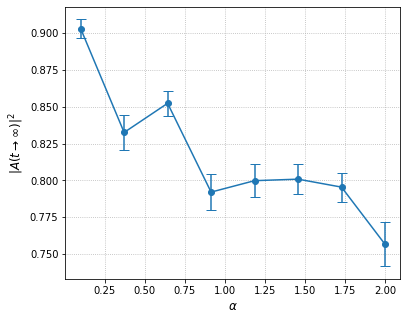

In [37]:
PLD_sigma = np.mean(PLD_magnon_dis2,axis=1)
PLD_E = np.std(PLD_magnon_dis2,axis=1)
sigma_list = np.linspace(0.1,2,8)

fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(sigma_list, PLD_sigma, PLD_E, marker = 'o', capsize= 5)
ax.set_xlabel(r'$\alpha$', fontsize=12)
ax.set_ylabel(r'$ |A(t\rightarrow \infty)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
#ax.legend(loc='upper right', prop={'size': 10})

plt.savefig('Asympt_Dynamics_Power_alpha.pdf',  bbox_inches='tight', dpi=300)
plt.show()

### Different lengths

In [70]:
# 'Dynamics Data'
mean = 1
sector = 1                                    
N_steps = 100
t_min = 2000
t_max = 2100
realizations = 1000
t_list = np.linspace(t_min,t_max,N_steps)

GD_magnon_L = []
GD_std_L = []
for L in np.arange(12,17,2):
    Sz = -L/2 +1 
    basisSzList = makeSzBasis(L)[sector]
    SiSj = SiSj_oper(basisSzList,L,0,1)
    GD_magnon_dis2 = [] 
    GD_std_dis2 = []
    
    for sigma in np.linspace(0.1,2,8):
        dyn_magnon, dyn_std = gauss_SiSjevol(SiSj,basisSzList,Sz,mean,sigma,realizations,t_min,t_max,N_steps,L)
        GD_magnon_dis2.append(dyn_magnon)
        GD_std_dis2.append(dyn_std)
    GD_magnon_L.append(GD_magnon_dis2)
    GD_std_L.append(GD_std_dis2)

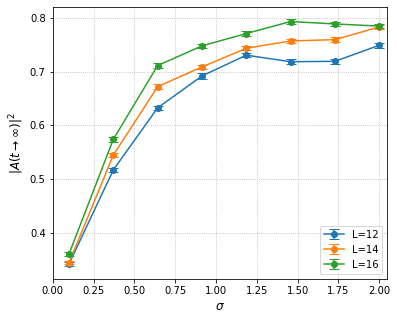

In [78]:
GD_sigma = []
GD_E = []

for GD_mag in GD_magnon_L:
    GD_sigma.append(np.mean(GD_mag,axis=1))
    GD_E.append(np.std(GD_mag,axis=1))

sigma_list = np.linspace(0.1,2,8)
fig, ax= plt.subplots(1,1,figsize = (6,5))
ax.errorbar(sigma_list, GD_sigma[0], GD_E[0], marker = 'o', capsize= 5,label = 'L=12')
ax.errorbar(sigma_list, GD_sigma[1], GD_E[1], marker = 'o', capsize= 5, label = 'L=14')
ax.errorbar(sigma_list, GD_sigma[2], GD_E[2], marker = 'o', capsize= 5, label = 'L=16')
ax.set_xlabel(r'$\sigma$', fontsize=12)
ax.set_ylabel(r'$ |A(t\rightarrow \infty)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
ax.set_xlim([0,2.05])
ax.legend(loc='lower right', prop={'size': 10})

plt.savefig('Asympt_Dynamics_Gauss_sigma.pdf',  bbox_inches='tight', dpi=300)
plt.show()

In [45]:
# 'Dynamics Data'
sector = 1                                    
N_steps = 100
t_min = 3000
t_max = 3100
realizations = 1000
t_list = np.linspace(t_min,t_max,N_steps)
alpha_list = np.array([2./5., 1./2., 2./3., 1., 5./4., 5./3., 5./2., 5., 10.])

PLD_magnon_L = []
PLD_std_L = []
for L in np.arange(12,17,2):
    Sz = -L/2 +1 
    basisSzList = makeSzBasis(L)[sector]
    SiSj = SiSj_oper(basisSzList,L,0,1)
    PLD_magnon_dis2 = [] 
    PLD_std_dis2 = []
    
    for sigma in alpha_list:
        dyn_magnon, dyn_std = power_SiSjevol(SiSj,basisSzList,Sz,sigma,realizations,t_min,t_max,N_steps,L)
        PLD_magnon_dis2.append(dyn_magnon)
        PLD_std_dis2.append(dyn_std)
    PLD_magnon_L.append(PLD_magnon_dis2)
    PLD_std_L.append(PLD_std_dis2)

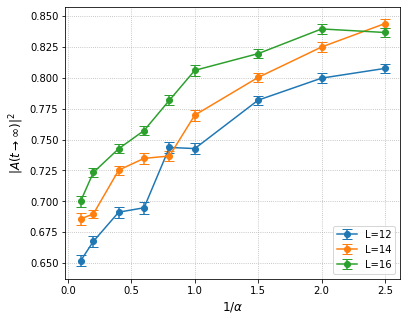

In [50]:
PLD_sigma = []
PLD_E = []

for PLD_mag in PLD_magnon_L:
    PLD_sigma.append(np.mean(PLD_mag,axis=1))
    PLD_E.append(np.std(PLD_mag,axis=1))

sigma_list = np.linspace(0.1,2,8)
fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(1/alpha_list, PLD_sigma[0], PLD_E[0], marker = 'o', capsize= 5,label = 'L=12')
ax.errorbar(1/alpha_list, PLD_sigma[1], PLD_E[1], marker = 'o', capsize= 5, label = 'L=14')
ax.errorbar(1/alpha_list, PLD_sigma[2], PLD_E[2], marker = 'o', capsize= 5, label = 'L=16')
ax.set_xlabel(r'$1/\alpha$', fontsize=12)
ax.set_ylabel(r'$ |A(t\rightarrow \infty)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
ax.legend(loc='lower right', prop={'size': 10})
#ax.set_xlim([0,2.05])

plt.savefig('Asympt_Dynamics_Power_sigma.pdf',  bbox_inches='tight', dpi=300)
plt.show()

### Asymptotic behavior for long chains

In [83]:
mean = 1
sector = 1
t = 2000
realizations = 1000
sigma_list = np.linspace(0.1,2.5,9)

GD_magnon_sigma = []
GD_std_sigma = []

for L in np.arange(10,27,2):
    Sz = -L/2 +1 
    basisSzList = makeSzBasis(L)[sector]
    SiSj = SiSj_oper(basisSzList,L,0,1)
    GD_magnon_sigma2 = []
    GD_std_sigma2 = []
    Sz = np.abs(Sz)
    
    for sigma in sigma_list:
        dyn_magnon = []
        for i in range(realizations):
            Jz = np.random.normal(mean,sigma,size = L)
            H = makeH(basisSzList,L,Jz,0)
            lam,eigv = np.linalg.eigh(H)
            num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
            num = np.random.randint(num)
            dyn_eigv = eigv[:,num]
            new_state = np.matmul(SiSj, dyn_eigv)
            new_state /= np.linalg.norm(new_state)
            
            exp_H = expm(-1.j*H*t)
            ev_state = np.matmul(exp_H,new_state)
            exp_val = np.vdot(new_state, ev_state)
            dyn_magnon.append(np.abs(exp_val)**2)
        gauss_mean_dyn = np.mean(dyn_magnon,axis=0)
        gauss_std_dyn = np.std(dyn_magnon,axis=0)
        GD_magnon_sigma2.append(gauss_mean_dyn)
        GD_std_sigma2.append(gauss_std_dyn)
    
    GD_magnon_sigma.append(GD_magnon_sigma2)
    GD_std_sigma.append(GD_std_sigma2)

In [85]:
GD_magnon_sigma = np.array(GD_magnon_sigma)
GD_std_sigma = np.array(GD_std_sigma)/np.sqrt(1000)


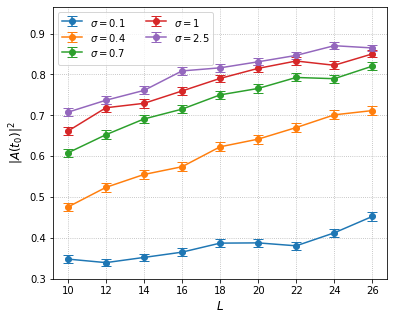

In [169]:
sigma_list = np.linspace(0.1,2,8)

fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,0], GD_std_sigma[:,0], marker = 'o', capsize= 5, label = r'$\sigma = 0.1$')
ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,1], GD_std_sigma[:,1], marker = 'o', capsize= 5, label = r'$\sigma = 0.4$')
ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,2], GD_std_sigma[:,2], marker = 'o', capsize= 5, label = r'$\sigma = 0.7$')
ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,3], GD_std_sigma[:,3], marker = 'o', capsize= 5, label = r'$\sigma = 1$')
#ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,4], GD_std_sigma[:,4], marker = 'o', capsize= 5, label = r'$\sigma = 1.3$')
#ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,5], GD_std_sigma[:,5], marker = 'o', capsize= 5, label = r'$\sigma = 1.6$')
#ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,6], GD_std_sigma[:,6], marker = 'o', capsize= 5, label = r'$\sigma = 2$')
#ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,7], GD_std_sigma[:,7], marker = 'o', capsize= 5, label = r'$\sigma = 2.2$')
ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,8], GD_std_sigma[:,8], marker = 'o', capsize= 5, label = r'$\sigma = 2.5$')
ax.set_xlabel(r'$L$', fontsize=12)
ax.set_ylabel(r'$ |A(t_0)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
ax.legend(loc='upper left', prop={'size': 10}, ncol=2, handleheight=1.9, labelspacing=0.05)
ax.set_ylim([0.3,0.965])

plt.savefig('Asympt_Dynamics_Gauss_L.pdf',  bbox_inches='tight', dpi=300)
plt.show()

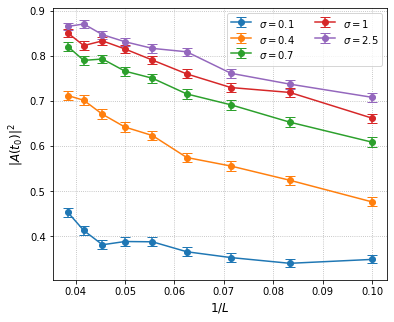

In [170]:
sigma_list = np.linspace(0.1,2,8)

fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(1/np.arange(10,27,2), GD_magnon_sigma[:,0], GD_std_sigma[:,0], marker = 'o', capsize= 5, label = r'$\sigma = 0.1$')
ax.errorbar(1/np.arange(10,27,2), GD_magnon_sigma[:,1], GD_std_sigma[:,1], marker = 'o', capsize= 5, label = r'$\sigma = 0.4$')
ax.errorbar(1/np.arange(10,27,2), GD_magnon_sigma[:,2], GD_std_sigma[:,2], marker = 'o', capsize= 5, label = r'$\sigma = 0.7$')
ax.errorbar(1/np.arange(10,27,2), GD_magnon_sigma[:,3], GD_std_sigma[:,3], marker = 'o', capsize= 5, label = r'$\sigma = 1$')
#ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,4], GD_std_sigma[:,4], marker = 'o', capsize= 5, label = r'$\sigma = 1.3$')
#ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,5], GD_std_sigma[:,5], marker = 'o', capsize= 5, label = r'$\sigma = 1.6$')
#ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,6], GD_std_sigma[:,6], marker = 'o', capsize= 5, label = r'$\sigma = 2$')
#ax.errorbar(np.arange(10,27,2), GD_magnon_sigma[:,7], GD_std_sigma[:,7], marker = 'o', capsize= 5, label = r'$\sigma = 2.2$')
ax.errorbar(1/np.arange(10,27,2), GD_magnon_sigma[:,8], GD_std_sigma[:,8], marker = 'o', capsize= 5, label = r'$\sigma = 2.5$')
ax.set_xlabel(r'$1/L$', fontsize=12)
ax.set_ylabel(r'$ |A(t_0)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
ax.legend(loc='upper right', prop={'size': 10}, ncol=2, handleheight=1.9, labelspacing=0.05)
#ax.set_xlim([0.,0.11])

plt.savefig('Asympt_Dynamics_Gauss_Linv.pdf',  bbox_inches='tight', dpi=300)
plt.show()

In [84]:
mean = 1
sector = 1
t = 2000
realizations = 1000
alpha_list = np.array([2./5., 1./2., 2./3., 1., 5./4., 5./3., 5./2., 5., 10.])

PLD_magnon_sigma = []
PLD_std_sigma = []

for L in np.arange(10,27,2):
    Sz = -L/2 +1 
    basisSzList = makeSzBasis(L)[sector]
    SiSj = SiSj_oper(basisSzList,L,0,1)
    PLD_magnon_sigma2 = []
    PLD_std_sigma2 = []
    Sz = np.abs(Sz)
    
    for dis in alpha_list:
        dyn_magnon = []
        for i in range(realizations):
            Jz = coupling_power_dist(dis,L)
            H = makeH(basisSzList,L,Jz,0)
            lam,eigv = np.linalg.eigh(H)
            num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
            num = np.random.randint(num)
            dyn_eigv = eigv[:,num]
            new_state = np.matmul(SiSj, dyn_eigv)
            new_state /= np.linalg.norm(new_state)
            
            exp_H = expm(-1.j*H*t)
            ev_state = np.matmul(exp_H,new_state)
            exp_val = np.vdot(new_state, ev_state)
            dyn_magnon.append(np.abs(exp_val)**2)
        gauss_mean_dyn = np.mean(dyn_magnon,axis=0)
        gauss_std_dyn = np.std(dyn_magnon,axis=0)
        PLD_magnon_sigma2.append(gauss_mean_dyn)
        PLD_std_sigma2.append(gauss_std_dyn)
    
    PLD_magnon_sigma.append(PLD_magnon_sigma2)
    PLD_std_sigma.append(PLD_std_sigma2)

In [92]:
PLD_magnon_sigma = np.array(PLD_magnon_sigma)
PLD_std_sigma = np.array(PLD_std_sigma)/np.sqrt(1000)

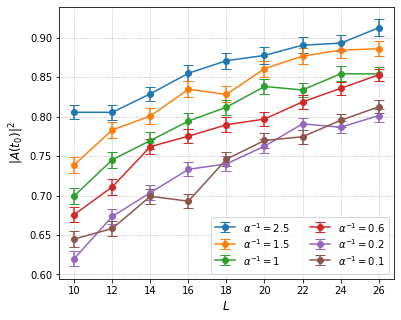

In [171]:

fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,0], GD_std_sigma[:,0], marker = 'o', capsize= 5, label = r'$\alpha^{-1}= 2.5$')
#ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,1], GD_std_sigma[:,1], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=2$')
ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,2], GD_std_sigma[:,2], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=1.5$')
ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,3], GD_std_sigma[:,3], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=1$')
#ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,4], GD_std_sigma[:,4], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.8$')
ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,5], GD_std_sigma[:,5], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.6$')
#ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,6], GD_std_sigma[:,6], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.4$')
ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,7], GD_std_sigma[:,7], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.2$')
ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,8], GD_std_sigma[:,8], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.1$')
ax.set_xlabel(r'$L$', fontsize=12)
ax.set_ylabel(r'$ |A(t_0)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
ax.legend(loc='lower right', prop={'size': 10},ncol=2, handleheight=1.9, labelspacing=0.05)

plt.savefig('Asympt_Dynamics_Power_L.pdf',  bbox_inches='tight', dpi=300)
plt.show()

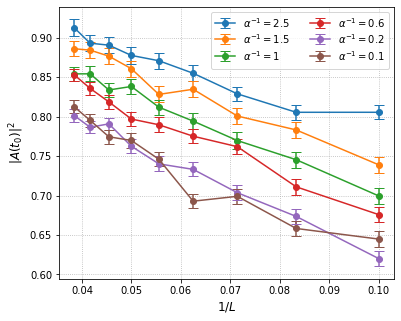

In [172]:

fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(1/np.arange(10,27,2), PLD_magnon_sigma[:,0], GD_std_sigma[:,0], marker = 'o', capsize= 5, label = r'$\alpha^{-1}= 2.5$')
#ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,1], GD_std_sigma[:,1], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=2$')
ax.errorbar(1/np.arange(10,27,2), PLD_magnon_sigma[:,2], GD_std_sigma[:,2], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=1.5$')
ax.errorbar(1/np.arange(10,27,2), PLD_magnon_sigma[:,3], GD_std_sigma[:,3], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=1$')
#ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,4], GD_std_sigma[:,4], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.8$')
ax.errorbar(1/np.arange(10,27,2), PLD_magnon_sigma[:,5], GD_std_sigma[:,5], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.6$')
#ax.errorbar(np.arange(10,27,2), PLD_magnon_sigma[:,6], GD_std_sigma[:,6], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.4$')
ax.errorbar(1/np.arange(10,27,2), PLD_magnon_sigma[:,7], GD_std_sigma[:,7], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.2$')
ax.errorbar(1/np.arange(10,27,2), PLD_magnon_sigma[:,8], GD_std_sigma[:,8], marker = 'o', capsize= 5, label = r'$\alpha^{-1}=0.1$')
ax.set_xlabel(r'$1/L$', fontsize=12)
ax.set_ylabel(r'$ |A(t_0)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
ax.legend(loc='upper right', prop={'size': 10},ncol=2, handleheight=1.9, labelspacing=0.05)

plt.savefig('Asympt_Dynamics_Power_Linv.pdf',  bbox_inches='tight', dpi=300)
plt.show()

### Time to arrive to steady state

In [88]:
realizations = 1000
t_min = 3000
t_max = 3100
N_steps = 100
t = 3000
mean = 1
sector = 1
alpha_list = np.array([2./5., 1./2., 2./3., 1., 5./4., 5./3., 5./2., 5., 10.])

t_dis_L = []
t_std_L = []

for L in np.arange(20,27,2):
    Sz = -L/2 +1 
    basisSzList = makeSzBasis(L)[sector]
    SiSj = SiSj_oper(basisSzList,L,0,1)
    Sz = np.abs(Sz)
    
    t_dis = []
    t_std_dis = []
    tic = time.perf_counter()
    for dis in alpha_list:
#        dyn_magnon = []
        gauss_mean_dyn, gauss_std_dyn = power_SiSjevol(SiSj,basisSzList,Sz,dis,realizations,t_min,t_max,N_steps,L)
#        for i in range(realizations):
#            Jz = coupling_power_dist(dis,L)
#            H = makeH(basisSzList,L,Jz,0)
#            lam,eigv = np.linalg.eigh(H)
#            num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
#            num = np.random.randint(num)
#            dyn_eigv = eigv[:,num]
#            new_state = np.matmul(SiSj, dyn_eigv)
#            new_state /= np.linalg.norm(new_state)
#            exp_H = expm(-1.j*H*t)
#            ev_state = np.matmul(exp_H,new_state)
#            exp_val = np.vdot(new_state, ev_state)
#            dyn_magnon.append(np.abs(exp_val)**2)
#        gauss_mean_dyn = np.mean(dyn_magnon,axis=0)
#        gauss_std_dyn = np.std(dyn_magnon,axis=0)
        A_std = gauss_mean_dyn + gauss_std_dyn/np.sqrt(realizations)
        print('We get the value {}'.format(A_std))
        dt = 0.01
        t_values = []
        for i in range(realizations):
            t = 0 
            A_ampl = 1
            Jz = coupling_power_dist(dis,L)
            H = makeH(basisSzList,L,Jz,0)
            lam,eigv = np.linalg.eigh(H)
            num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
            num = np.random.randint(num)
            dyn_eigv = eigv[:,num]
            new_state = np.matmul(SiSj, dyn_eigv)
            new_state /= np.linalg.norm(new_state)
            
            while (A_ampl > A_std):
                exp_H = expm(-1.j*H*t)
                ev_state = np.matmul(exp_H,new_state)
                A_ampl = np.vdot(new_state, ev_state)
                t+= dt
            print('The value of the time t = {}'.format(t))
            t_values.append(t)
        t_mean = np.mean(t_values)
        t_std = np.std(t_values)
        t_dis.append(t_mean)
        t_std_dis.append(t_std)
        toc = time.perf_counter()
        print('Time to finish for L = {}: {}'.format(L,toc-tic))
    t_dis_L.append(t_dis)
    t_std_L.append(t_std_dis)

We get the value 0.8874545394931465
The value of the time t = 1.430000000000001
The value of the time t = 2.629999999999988
The value of the time t = 1.0900000000000007
The value of the time t = 20.890000000000466
The value of the time t = 0.6900000000000004
The value of the time t = 12.999999999999767
The value of the time t = 1.0000000000000007
The value of the time t = 0.8800000000000006
The value of the time t = 0.8500000000000005
The value of the time t = 2.1399999999999983
The value of the time t = 1.9000000000000015
The value of the time t = 1.9400000000000015
The value of the time t = 1.300000000000001
The value of the time t = 1.8600000000000014
The value of the time t = 1.450000000000001
The value of the time t = 7.379999999999887
The value of the time t = 3.4999999999999694
The value of the time t = 4.649999999999945
The value of the time t = 1.8300000000000014
The value of the time t = 2.7499999999999853
The value of the time t = 0.8800000000000006
The value of the time t =

The value of the time t = 3.00999999999998
The value of the time t = 1.300000000000001
The value of the time t = 4.149999999999956
The value of the time t = 3.419999999999971
The value of the time t = 1.6300000000000012
The value of the time t = 1.6500000000000012
The value of the time t = 16.49999999999978
The value of the time t = 2.349999999999994
The value of the time t = 0.7400000000000004
The value of the time t = 1.0200000000000007
The value of the time t = 3.1999999999999758
The value of the time t = 2.9699999999999807
The value of the time t = 0.5100000000000002
The value of the time t = 4.659999999999945
The value of the time t = 1.1200000000000008
The value of the time t = 1.440000000000001
The value of the time t = 18.010000000000016
The value of the time t = 3.1599999999999766
The value of the time t = 12.329999999999782
The value of the time t = 2.8399999999999834
The value of the time t = 0.9100000000000006
The value of the time t = 1.6600000000000013
The value of the ti

The value of the time t = 1.410000000000001
The value of the time t = 1.2300000000000009
The value of the time t = 0.48000000000000026
The value of the time t = 2.53999999999999
The value of the time t = 0.5900000000000003
The value of the time t = 1.2000000000000008
The value of the time t = 1.1000000000000008
The value of the time t = 0.8800000000000006
The value of the time t = 0.5600000000000003
The value of the time t = 0.5500000000000003
The value of the time t = 0.6700000000000004
The value of the time t = 0.9700000000000006
The value of the time t = 1.260000000000001
The value of the time t = 4.179999999999955
The value of the time t = 0.6800000000000004
The value of the time t = 1.7100000000000013
The value of the time t = 1.270000000000001
The value of the time t = 2.020000000000001
The value of the time t = 1.1700000000000008
The value of the time t = 1.280000000000001
The value of the time t = 6.249999999999911
The value of the time t = 1.6600000000000013
The value of the t

The value of the time t = 0.7900000000000005
The value of the time t = 1.320000000000001
The value of the time t = 1.2300000000000009
The value of the time t = 1.470000000000001
The value of the time t = 12.129999999999786
The value of the time t = 0.37000000000000016
The value of the time t = 15.769999999999708
The value of the time t = 1.1300000000000008
The value of the time t = 0.9900000000000007
The value of the time t = 0.7300000000000004
The value of the time t = 4.089999999999957
The value of the time t = 3.45999999999997
The value of the time t = 2.769999999999985
The value of the time t = 138.65000000001888
The value of the time t = 6.339999999999909
The value of the time t = 0.8500000000000005
The value of the time t = 2.7999999999999843
The value of the time t = 3.0599999999999787
The value of the time t = 0.9100000000000006
The value of the time t = 0.5200000000000002
The value of the time t = 1.1300000000000008
The value of the time t = 1.8400000000000014
The value of the

The value of the time t = 0.9800000000000006
The value of the time t = 3.1599999999999766
The value of the time t = 1.430000000000001
The value of the time t = 0.9600000000000006
The value of the time t = 1.5200000000000011
The value of the time t = 33.96000000000181
The value of the time t = 1.2300000000000009
The value of the time t = 0.47000000000000025
The value of the time t = 4.079999999999957
The value of the time t = 1.5200000000000011
The value of the time t = 0.7400000000000004
The value of the time t = 0.9800000000000006
The value of the time t = 1.0100000000000007
The value of the time t = 0.9400000000000006
The value of the time t = 9.879999999999834
The value of the time t = 4.059999999999958
The value of the time t = 1.1900000000000008
The value of the time t = 0.9600000000000006
The value of the time t = 2.4599999999999915
The value of the time t = 8.799999999999857
The value of the time t = 0.9500000000000006
The value of the time t = 0.8400000000000005
The value of th

The value of the time t = 0.7400000000000004
The value of the time t = 0.4100000000000002
The value of the time t = 0.8000000000000005
The value of the time t = 1.7600000000000013
The value of the time t = 1.6900000000000013
The value of the time t = 1.1100000000000008
The value of the time t = 2.6499999999999875
The value of the time t = 1.1000000000000008
The value of the time t = 1.490000000000001
The value of the time t = 1.450000000000001
The value of the time t = 1.1500000000000008
The value of the time t = 2.099999999999999
The value of the time t = 2.7399999999999856
The value of the time t = 2.759999999999985
The value of the time t = 0.6500000000000004
The value of the time t = 1.300000000000001
The value of the time t = 0.7700000000000005
The value of the time t = 1.9300000000000015
The value of the time t = 1.7700000000000014
The value of the time t = 1.8800000000000014
The value of the time t = 1.2300000000000009
The value of the time t = 96.66000000001254
The value of the

The value of the time t = 2.479999999999991
The value of the time t = 1.2000000000000008
The value of the time t = 3.379999999999972
The value of the time t = 2.3099999999999947
The value of the time t = 4.179999999999955
The value of the time t = 0.6100000000000003
The value of the time t = 0.7800000000000005
The value of the time t = 0.9400000000000006
The value of the time t = 2.6599999999999873
The value of the time t = 2.2699999999999956
The value of the time t = 7.189999999999891
The value of the time t = 4.599999999999946
The value of the time t = 0.7100000000000004
The value of the time t = 1.480000000000001
The value of the time t = 3.429999999999971
The value of the time t = 23.270000000000838
The value of the time t = 0.6600000000000004
The value of the time t = 1.7200000000000013
The value of the time t = 1.0500000000000007
The value of the time t = 1.8700000000000014
The value of the time t = 4.629999999999946
The value of the time t = 0.9300000000000006
The value of the t

The value of the time t = 0.4100000000000002
The value of the time t = 1.8500000000000014
The value of the time t = 1.1400000000000008
The value of the time t = 0.35000000000000014
The value of the time t = 1.5900000000000012
The value of the time t = 2.7499999999999853
The value of the time t = 2.0000000000000013
The value of the time t = 1.360000000000001
The value of the time t = 0.5600000000000003
The value of the time t = 2.899999999999982
The value of the time t = 0.7000000000000004
The value of the time t = 0.8700000000000006
The value of the time t = 1.360000000000001
The value of the time t = 2.199999999999997
The value of the time t = 0.4200000000000002
The value of the time t = 1.470000000000001
The value of the time t = 0.8200000000000005
The value of the time t = 0.46000000000000024
The value of the time t = 1.8600000000000014
The value of the time t = 1.1400000000000008
The value of the time t = 23.48000000000087
The value of the time t = 6.349999999999909
The value of th

The value of the time t = 6.449999999999907
The value of the time t = 0.8200000000000005
The value of the time t = 0.8700000000000006
The value of the time t = 1.260000000000001
The value of the time t = 1.1200000000000008
The value of the time t = 0.9300000000000006
The value of the time t = 1.0200000000000007
The value of the time t = 0.8100000000000005
The value of the time t = 2.0400000000000005
The value of the time t = 0.8400000000000005
The value of the time t = 1.0600000000000007
The value of the time t = 39.630000000000685
The value of the time t = 10.49999999999982
The value of the time t = 13.729999999999752
The value of the time t = 2.429999999999992
The value of the time t = 0.6000000000000003
The value of the time t = 6.7799999999999
The value of the time t = 1.2500000000000009
The value of the time t = 2.0799999999999996
The value of the time t = 1.460000000000001
The value of the time t = 0.5000000000000002
The value of the time t = 1.320000000000001
The value of the ti

The value of the time t = 3.659999999999966
The value of the time t = 8.919999999999854
The value of the time t = 1.5500000000000012
The value of the time t = 0.9900000000000007
The value of the time t = 1.390000000000001
The value of the time t = 0.5600000000000003
The value of the time t = 1.6400000000000012
The value of the time t = 29.060000000001743
The value of the time t = 1.1700000000000008
The value of the time t = 9.58999999999984
The value of the time t = 0.6400000000000003
The value of the time t = 0.6900000000000004
The value of the time t = 0.3100000000000001
The value of the time t = 0.9500000000000006
The value of the time t = 7.959999999999875
The value of the time t = 1.260000000000001
The value of the time t = 2.4999999999999907
The value of the time t = 3.6399999999999664
The value of the time t = 0.5100000000000002
The value of the time t = 0.4400000000000002
The value of the time t = 1.2300000000000009
The value of the time t = 1.7300000000000013
The value of the 

The value of the time t = 3.1299999999999772
The value of the time t = 1.7600000000000013
The value of the time t = 1.2100000000000009
The value of the time t = 1.2400000000000009
The value of the time t = 0.49000000000000027
The value of the time t = 1.290000000000001
The value of the time t = 2.1299999999999986
The value of the time t = 1.2300000000000009
The value of the time t = 1.0700000000000007
The value of the time t = 1.480000000000001
The value of the time t = 1.7200000000000013
The value of the time t = 4.709999999999944
The value of the time t = 1.6400000000000012
The value of the time t = 117.06000000002298
The value of the time t = 1.0100000000000007
The value of the time t = 0.5500000000000003
The value of the time t = 0.5700000000000003
The value of the time t = 1.0200000000000007
The value of the time t = 0.5900000000000003
The value of the time t = 1.290000000000001
The value of the time t = 3.1299999999999772
The value of the time t = 0.7000000000000004
The value of 

The value of the time t = 0.25000000000000006
The value of the time t = 0.5000000000000002
The value of the time t = 0.36000000000000015
The value of the time t = 0.3200000000000001
The value of the time t = 0.5900000000000003
The value of the time t = 1.370000000000001
The value of the time t = 0.5400000000000003
The value of the time t = 0.6600000000000004
The value of the time t = 0.25000000000000006
The value of the time t = 0.5300000000000002
The value of the time t = 0.18000000000000002
The value of the time t = 1.1900000000000008
The value of the time t = 0.21000000000000005
The value of the time t = 0.3300000000000001
The value of the time t = 0.7200000000000004
The value of the time t = 0.21000000000000005
The value of the time t = 0.7200000000000004
The value of the time t = 0.37000000000000016
The value of the time t = 0.6500000000000004
The value of the time t = 0.6100000000000003
The value of the time t = 0.3100000000000001
The value of the time t = 0.9400000000000006
The 

The value of the time t = 0.5400000000000003
The value of the time t = 0.3900000000000002
The value of the time t = 0.3000000000000001
The value of the time t = 2.020000000000001
The value of the time t = 0.3900000000000002
The value of the time t = 0.19000000000000003
The value of the time t = 0.2800000000000001
The value of the time t = 0.5600000000000003
The value of the time t = 0.34000000000000014
The value of the time t = 0.21000000000000005
The value of the time t = 0.3900000000000002
The value of the time t = 0.5300000000000002
The value of the time t = 1.400000000000001
The value of the time t = 0.6200000000000003
The value of the time t = 0.2700000000000001
The value of the time t = 0.4000000000000002
The value of the time t = 0.9200000000000006
The value of the time t = 0.6600000000000004
The value of the time t = 2.0400000000000005
The value of the time t = 0.5100000000000002
The value of the time t = 0.5700000000000003
The value of the time t = 0.6400000000000003
The value

The value of the time t = 2.339999999999994
The value of the time t = 0.16
The value of the time t = 0.22000000000000006
The value of the time t = 0.21000000000000005
The value of the time t = 0.8000000000000005
The value of the time t = 0.26000000000000006
The value of the time t = 3.92999999999996
The value of the time t = 2.3099999999999947
The value of the time t = 0.8300000000000005
The value of the time t = 1.8000000000000014
The value of the time t = 0.3000000000000001
The value of the time t = 0.3300000000000001
The value of the time t = 0.45000000000000023
The value of the time t = 1.1900000000000008
The value of the time t = 0.5300000000000002
The value of the time t = 0.34000000000000014
The value of the time t = 0.5200000000000002
The value of the time t = 0.38000000000000017
The value of the time t = 1.5100000000000011
The value of the time t = 0.6700000000000004
The value of the time t = 1.6300000000000012
The value of the time t = 1.380000000000001
The value of the time 

The value of the time t = 0.46000000000000024
The value of the time t = 0.18000000000000002
The value of the time t = 0.7500000000000004
The value of the time t = 0.45000000000000023
The value of the time t = 1.8600000000000014
The value of the time t = 0.5500000000000003
The value of the time t = 0.18000000000000002
The value of the time t = 0.23000000000000007
The value of the time t = 0.19000000000000003
The value of the time t = 1.300000000000001
The value of the time t = 3.089999999999978
The value of the time t = 0.4200000000000002
The value of the time t = 0.20000000000000004
The value of the time t = 0.4300000000000002
The value of the time t = 0.5200000000000002
The value of the time t = 0.5100000000000002
The value of the time t = 0.19000000000000003
The value of the time t = 0.2900000000000001
The value of the time t = 0.26000000000000006
The value of the time t = 0.8400000000000005
The value of the time t = 0.4000000000000002
The value of the time t = 0.26000000000000006
Th

The value of the time t = 0.6500000000000004
The value of the time t = 0.24000000000000007
The value of the time t = 0.9600000000000006
The value of the time t = 1.8600000000000014
The value of the time t = 0.35000000000000014
The value of the time t = 0.36000000000000015
The value of the time t = 0.3900000000000002
The value of the time t = 0.48000000000000026
The value of the time t = 0.8300000000000005
The value of the time t = 1.6300000000000012
The value of the time t = 0.7700000000000005
The value of the time t = 2.0000000000000013
The value of the time t = 0.3100000000000001
The value of the time t = 0.7500000000000004
The value of the time t = 0.4100000000000002
The value of the time t = 0.9600000000000006
The value of the time t = 0.5100000000000002
The value of the time t = 0.24000000000000007
The value of the time t = 0.38000000000000017
The value of the time t = 1.6200000000000012
The value of the time t = 0.47000000000000025
The value of the time t = 0.5500000000000003
The

The value of the time t = 1.8200000000000014
The value of the time t = 1.1800000000000008
The value of the time t = 0.37000000000000016
The value of the time t = 0.2700000000000001
The value of the time t = 0.3300000000000001
The value of the time t = 0.4400000000000002
The value of the time t = 0.37000000000000016
The value of the time t = 0.25000000000000006
The value of the time t = 0.17
The value of the time t = 0.2800000000000001
The value of the time t = 0.23000000000000007
The value of the time t = 0.5800000000000003
The value of the time t = 0.5400000000000003
The value of the time t = 0.5100000000000002
The value of the time t = 1.6200000000000012
The value of the time t = 1.8900000000000015
The value of the time t = 0.37000000000000016
The value of the time t = 0.6600000000000004
The value of the time t = 0.5500000000000003
The value of the time t = 0.6600000000000004
The value of the time t = 0.9200000000000006
The value of the time t = 0.49000000000000027
The value of the t

The value of the time t = 0.6000000000000003
The value of the time t = 0.38000000000000017
The value of the time t = 0.12999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.11999999999999998
The value of the time t = 0.11999999999999998
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.16
The value of the time t = 0.24000000000000007
The value of the time t = 0.22000000000000006
The value of the time t = 0.09
The value of the time t = 0.12999999999999998
The value of the time t = 0.09999999999999999
The value of the time t = 0.35000000000000014
The value of the time t = 0.25000000000000006
The value of the time t = 0.19000000000000003
The value of the time t = 0.3300000000000001
The value of the time t = 0.36000000000000015
The value of the time t = 0.19000000000000003
The value of the time t = 0.10999999999999999
The value of the time t = 0.5200000000000002
The value of the time

The value of the time t = 0.21000000000000005
The value of the time t = 0.2700000000000001
The value of the time t = 0.19000000000000003
The value of the time t = 0.23000000000000007
The value of the time t = 0.12999999999999998
The value of the time t = 0.15
The value of the time t = 18.840000000000146
The value of the time t = 0.18000000000000002
The value of the time t = 0.13999999999999999
The value of the time t = 0.15
The value of the time t = 0.13999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.26000000000000006
The value of the time t = 0.13999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.10999999999999999
The value of the time t = 0.09
The value of the time t = 0.09
The value of the time t = 0.11999999999999998
The value of the time t = 0.3300000000000001
The value of the time t = 0.09
The value of the time t = 0.3200000000000001
The value of the time t = 1.270000000000001
The value of the time t

The value of the time t = 0.4000000000000002
The value of the time t = 0.20000000000000004
The value of the time t = 0.24000000000000007
The value of the time t = 0.19000000000000003
The value of the time t = 0.17
The value of the time t = 0.07
The value of the time t = 0.10999999999999999
The value of the time t = 0.16
The value of the time t = 0.3100000000000001
The value of the time t = 0.17
The value of the time t = 0.12999999999999998
The value of the time t = 0.37000000000000016
The value of the time t = 0.3200000000000001
The value of the time t = 0.08
The value of the time t = 0.17
The value of the time t = 0.10999999999999999
The value of the time t = 0.2700000000000001
The value of the time t = 0.3200000000000001
The value of the time t = 0.10999999999999999
The value of the time t = 0.20000000000000004
The value of the time t = 0.20000000000000004
The value of the time t = 0.17
The value of the time t = 0.18000000000000002
The value of the time t = 0.19000000000000003
The va

The value of the time t = 0.6000000000000003
The value of the time t = 0.09999999999999999
The value of the time t = 0.18000000000000002
The value of the time t = 0.6100000000000003
The value of the time t = 0.18000000000000002
The value of the time t = 0.25000000000000006
The value of the time t = 0.22000000000000006
The value of the time t = 0.18000000000000002
The value of the time t = 0.4300000000000002
The value of the time t = 0.34000000000000014
The value of the time t = 0.23000000000000007
The value of the time t = 0.25000000000000006
The value of the time t = 0.12999999999999998
The value of the time t = 0.16
The value of the time t = 0.10999999999999999
The value of the time t = 0.17
The value of the time t = 0.13999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.21000000000000005
The value of the time t = 0.34000000000000014
The value of the time t = 0.2800000000000001
The value of the time t = 0.09999999999999999
The value of the time 

The value of the time t = 0.38000000000000017
The value of the time t = 0.21000000000000005
The value of the time t = 0.12999999999999998
The value of the time t = 0.25000000000000006
The value of the time t = 0.25000000000000006
The value of the time t = 0.24000000000000007
The value of the time t = 25.030000000001113
The value of the time t = 0.15
The value of the time t = 1.6200000000000012
The value of the time t = 0.4300000000000002
The value of the time t = 0.4000000000000002
The value of the time t = 0.11999999999999998
The value of the time t = 0.16
The value of the time t = 0.09999999999999999
The value of the time t = 0.17
The value of the time t = 0.13999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 0.3000000000000001
The value of the time t = 0.3100000000000001
The value of the time t = 0.19000000000000003
The value of the time t = 0.4300000000000002
The value of the time t = 0.12999999999999998
The value of the time t = 0.390000000000

The value of the time t = 0.09999999999999999
The value of the time t = 0.16
The value of the time t = 0.9000000000000006
The value of the time t = 0.08
The value of the time t = 0.7900000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.48000000000000026
The value of the time t = 0.08
The value of the time t = 0.09999999999999999
The value of the time t = 0.09
The value of the time t = 0.09999999999999999
The value of the time t = 0.34000000000000014
The value of the time t = 0.10999999999999999
The value of the time t = 0.16
The value of the time t = 0.18000000000000002
The value of the time t = 0.08
The value of the time t = 0.10999999999999999
The value of the time t = 0.3100000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.2700000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.86000000

The value of the time t = 0.5700000000000003
The value of the time t = 0.10999999999999999
The value of the time t = 0.23000000000000007
The value of the time t = 0.5500000000000003
The value of the time t = 0.12999999999999998
The value of the time t = 0.09
The value of the time t = 0.09999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 0.2700000000000001
The value of the time t = 0.11999999999999998
The value of the time t = 0.37000000000000016
The value of the time t = 0.16
The value of the time t = 0.11999999999999998
The value of the time t = 0.16
The value of the time t = 0.22000000000000006
The value of the time t = 0.19000000000000003
The value of the time t = 0.07
The value of the time t = 0.22000000000000006
The value of the time t = 0.26000000000000006
The value of the time t = 0.21000000000000005
The value of the time t = 0.08
The value of the time t = 0.23000000000000007
The value of the time t = 1.0500000000000007
The value of the time

The value of the time t = 0.9400000000000006
The value of the time t = 0.12999999999999998
The value of the time t = 0.4100000000000002
The value of the time t = 0.13999999999999999
The value of the time t = 0.3000000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.24000000000000007
The value of the time t = 0.11999999999999998
The value of the time t = 0.07
The value of the time t = 0.19000000000000003
The value of the time t = 0.19000000000000003
The value of the time t = 0.13999999999999999
The value of the time t = 0.17
The value of the time t = 0.5300000000000002
The value of the time t = 0.16
The value of the time t = 0.08
The value of the time t = 0.16
The value of the time t = 0.34000000000000014
The value of the time t = 0.10999999999999999
The value of the time t = 0.4100000000000002
The value of the time t = 0.10999999999999999
The value of the time t = 0.15
The value of the time t = 0.11999999999999998
The value of the time t = 0.360000000

The value of the time t = 0.17
The value of the time t = 17.44999999999993
The value of the time t = 0.34000000000000014
The value of the time t = 0.09
The value of the time t = 0.09
The value of the time t = 0.35000000000000014
The value of the time t = 0.7100000000000004
The value of the time t = 0.09
The value of the time t = 0.19000000000000003
The value of the time t = 0.24000000000000007
The value of the time t = 0.09
The value of the time t = 0.15
The value of the time t = 0.24000000000000007
The value of the time t = 0.09
The value of the time t = 0.19000000000000003
The value of the time t = 0.19000000000000003
The value of the time t = 0.07
The value of the time t = 0.19000000000000003
The value of the time t = 0.8000000000000005
The value of the time t = 0.21000000000000005
The value of the time t = 0.5400000000000003
The value of the time t = 0.09999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.09
The value of the time t = 0.08
The v

The value of the time t = 0.15
The value of the time t = 0.10999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.12999999999999998
The value of the time t = 0.23000000000000007
The value of the time t = 0.20000000000000004
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.16
The value of the time t = 0.17
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.11999999999999998
The value of the time t = 0.18000000000000002
The value of the time t = 0.13999999999999999
The value of the time t = 0.07
The value of the time t = 0.12999999999999998
The value of the time t = 0.20000000000000004
The value of the time t = 0.07
The value of the time t = 0.19000000000000003
The value of the time t = 0.16
The value of the time t = 0.15
The value of the time t = 0.3

The value of the time t = 0.11999999999999998
The value of the time t = 0.09
The value of the time t = 0.2900000000000001
The value of the time t = 0.10999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.2700000000000001
The value of the time t = 0.20000000000000004
The value of the time t = 0.18000000000000002
The value of the time t = 0.2900000000000001
The value of the time t = 0.15
The value of the time t = 0.09
The value of the time t = 0.2800000000000001
The value of the time t = 0.10999999999999999
The value of the time t = 0.08
The value of the time t = 0.3900000000000002
The value of the time t = 0.13999999999999999
The value of the time t = 0.18000000000000002
The value of the time t = 0.15
The value of the time t = 0.23000000000000007
The value of the time t = 0.09999999999999999
The value of the time t = 0.15
The value of the time t = 0.15
The value of the time t = 0.10999999999999999
The value of the time t = 0.16
The value of the time

The value of the time t = 0.15
The value of the time t = 0.17
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.12999999999999998
The value of the time t = 0.13999999999999999
The value of the time t = 0.4100000000000002
The value of the time t = 0.4100000000000002
The value of the time t = 0.09999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.23000000000000007
The value of the time t = 0.19000000000000003
The value of the time t = 0.09999999999999999
The value of the time t = 0.17
The value of the time t = 0.3300000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.09
The value of the time t = 0.15
The value of the time t = 0.34000000000000014
The value of the time t = 0.46000000000000024
The value of the time t = 0.12999999999999998
The value of the time t = 0.09999999999999999
The value of the time t = 0.37000000000000016
The value of the time t = 0.13999999999999999
The 

The value of the time t = 0.22000000000000006
The value of the time t = 0.07
The value of the time t = 5.479999999999928
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 1.2100000000000009
The value of the time t = 1.1100000000000008
The value of the time t = 0.09
The value of the time t = 0.16
The value of the time t = 0.13999999999999999
The value of the time t = 0.09
The value of the time t = 0.38000000000000017
The value of the time t = 0.34000000000000014
The value of the time t = 0.10999999999999999
The value of the time t = 0.15
The value of the time t = 1.5200000000000011
The value of the time t = 0.22000000000000006
The value of the time t = 0.11999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.09
The value of the time t = 0.3100000000000001
The value of the time t = 0.8200000000000005
The value of the time t = 0.11999999999999998
The value of the time t = 0.26000000000000006
The value of the time t

The value of the time t = 0.8200000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.08
The value of the time t = 0.45000000000000023
The value of the time t = 0.12999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.09
The value of the time t = 0.9200000000000006
The value of the time t = 0.3000000000000001
The value of the time t = 0.19000000000000003
The value of the time t = 0.09999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.3100000000000001
The value of the time t = 0.16
The value of the time t = 0.09999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.15
The value of the time t = 0.12999999999999998
The value of the time t = 0.13999999999999999
The value of the time t = 0.13999999999999999
The value of the time t = 0.13999999999999999
The va

The value of the time t = 1.360000000000001
The value of the time t = 0.22000000000000006
The value of the time t = 0.12999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.10999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 0.19000000000000003
The value of the time t = 0.11999999999999998
The value of the time t = 0.13999999999999999
The value of the time t = 0.15
The value of the time t = 0.09
The value of the time t = 0.11999999999999998
The value of the time t = 0.13999999999999999
The value of the time t = 0.16
The value of the time t = 0.2700000000000001
The value of the time t = 0.10999999999999999
The value of the time t = 0.2900000000000001
The value of the time t = 0.11999999999999998
The value of the time t = 0.20000000000000004
The value of the time t = 0.12999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.09
The value of the time t = 0.09999999999999999
The v

The value of the time t = 0.5300000000000002
The value of the time t = 0.21000000000000005
The value of the time t = 0.16
The value of the time t = 0.6300000000000003
The value of the time t = 0.3000000000000001
The value of the time t = 0.15
The value of the time t = 0.11999999999999998
The value of the time t = 0.49000000000000027
The value of the time t = 0.09999999999999999
The value of the time t = 0.15
The value of the time t = 0.19000000000000003
The value of the time t = 0.2900000000000001
The value of the time t = 0.09
The value of the time t = 0.17
The value of the time t = 0.5100000000000002
The value of the time t = 0.15
The value of the time t = 0.4100000000000002
The value of the time t = 0.19000000000000003
The value of the time t = 1.340000000000001
The value of the time t = 0.11999999999999998
The value of the time t = 0.17
The value of the time t = 0.20000000000000004
The value of the time t = 0.15
The value of the time t = 0.13999999999999999
The value of the time t 

The value of the time t = 0.17
The value of the time t = 0.11999999999999998
The value of the time t = 0.20000000000000004
The value of the time t = 0.15
The value of the time t = 0.19000000000000003
The value of the time t = 0.10999999999999999
The value of the time t = 0.18000000000000002
The value of the time t = 0.3200000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.22000000000000006
The value of the time t = 0.23000000000000007
The value of the time t = 0.16
The value of the time t = 0.17
The value of the time t = 0.09999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.5100000000000002
The value of the time t = 0.17
The value of the time t = 0.2800000000000001
The value of the time t = 0.25000000000000006
The value of the time t = 0.15
The value of the time t = 0.5900000000000003
The value of the time t = 0.2700000000000001
The value of the time t = 0.3300000000000001
The value of the time t = 0.1099999999

The value of the time t = 0.4400000000000002
The value of the time t = 0.3000000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.4100000000000002
The value of the time t = 0.3300000000000001
The value of the time t = 0.3100000000000001
The value of the time t = 0.2800000000000001
The value of the time t = 0.5700000000000003
The value of the time t = 0.09999999999999999
The value of the time t = 0.2700000000000001
The value of the time t = 0.38000000000000017
The value of the time t = 0.13999999999999999
The value of the time t = 0.2800000000000001
The value of the time t = 0.18000000000000002
The value of the time t = 0.11999999999999998
The value of the time t = 0.11999999999999998
The value of the time t = 0.22000000000000006
The value of the time t = 0.2800000000000001
The value of the time t = 0.23000000000000007
The value of the time t = 0.2700000000000001
The value of the time t = 0.20000000000000004

The value of the time t = 3.0199999999999796
The value of the time t = 2.0000000000000013
The value of the time t = 0.3000000000000001
The value of the time t = 0.17
The value of the time t = 0.25000000000000006
The value of the time t = 1.1400000000000008
The value of the time t = 0.15
The value of the time t = 0.16
The value of the time t = 0.18000000000000002
The value of the time t = 0.15
The value of the time t = 0.12999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.4000000000000002
The value of the time t = 0.2800000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.9600000000000006
The value of the time t = 0.16
The value of the time t = 0.13999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.16
The value of the time t = 0.15
The value of the time t = 0.2900000000000001
The value of the time t = 0.24000000000000007
The value of the time t = 0.24000000000000007
The value

The value of the time t = 0.12999999999999998
The value of the time t = 0.37000000000000016
The value of the time t = 0.10999999999999999
The value of the time t = 0.38000000000000017
The value of the time t = 0.2900000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.13999999999999999
The value of the time t = 0.23000000000000007
The value of the time t = 0.09
The value of the time t = 0.34000000000000014
The value of the time t = 0.3900000000000002
The value of the time t = 0.3100000000000001
The value of the time t = 0.11999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.19000000000000003
The value of the time t = 0.16
The value of the time t = 0.22000000000000006
The value of the time t = 0.15
The value of the time t = 0.21000000000000005
The value of the time t = 0.17
The value of the time t = 0.3200000000000001
The value of the time t = 0.26000000000000006
The value of the time t = 0.21000000000000005
The va

The value of the time t = 0.4300000000000002
The value of the time t = 0.09
The value of the time t = 0.11999999999999998
The value of the time t = 0.7700000000000005
The value of the time t = 0.13999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.15
The value of the time t = 3.229999999999975
The value of the time t = 0.08
The value of the time t = 0.09999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.25000000000000006
The value of the time t = 0.19000000000000003
The value of the time t = 0.07
The value of the time t = 0.09999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 0.26000000000000006
The value of the time t = 0.17
The value of the time t = 0.09999999999999999
The value of the time t = 0.12999999999999998
The value of the time

The value of the time t = 0.16
The value of the time t = 0.22000000000000006
The value of the time t = 0.13999999999999999
The value of the time t = 0.35000000000000014
The value of the time t = 0.11999999999999998
The value of the time t = 0.2800000000000001
The value of the time t = 0.18000000000000002
The value of the time t = 0.19000000000000003
The value of the time t = 0.10999999999999999
The value of the time t = 0.4000000000000002
The value of the time t = 0.24000000000000007
The value of the time t = 0.18000000000000002
The value of the time t = 0.09
The value of the time t = 0.23000000000000007
The value of the time t = 0.12999999999999998
The value of the time t = 0.11999999999999998
The value of the time t = 0.3100000000000001
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.2900000000000001
The value of the time t = 0.23000000000000007
The value of the time t = 0.3000000000000001
The value of the time t = 0.16
The value of the time 

The value of the time t = 0.11999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.16
The value of the time t = 0.5900000000000003
The value of the time t = 0.10999999999999999
The value of the time t = 0.2800000000000001
The value of the time t = 0.17
The value of the time t = 0.12999999999999998
The value of the time t = 0.2900000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.13999999999999999
The value of the time t = 0.23000000000000007
The value of the time t = 0.20000000000000004
The value of the time t = 0.19000000000000003
The value of the time t = 0.24000000000000007
The value of the time t = 0.09
The value of the time t = 0.11999999999999998
The value of the time t = 0.15
The value of the time t = 0.20000000000000004
The value of the time t = 0.20000000000000004
The value of the time t = 0.12999999999999998
The value of the time t = 0.09
The value of the time t = 0.3300000000000001
The value of the time

The value of the time t = 0.2700000000000001
The value of the time t = 0.09
The value of the time t = 0.26000000000000006
The value of the time t = 0.10999999999999999
The value of the time t = 0.16
The value of the time t = 0.3100000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.13999999999999999
The value of the time t = 0.22000000000000006
The value of the time t = 0.23000000000000007
The value of the time t = 0.11999999999999998
The value of the time t = 0.10999999999999999
The value of the time t = 0.17
The value of the time t = 0.11999999999999998
The value of the time t = 0.16
The value of the time t = 0.09999999999999999
The value of the time t = 0.17
The value of the time t = 0.10999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.08
The value of the time t = 0.4300000000000002
The value of the time t = 0.09999999999999999
The value of the time t = 0.13999999999999999
The value of the time t = 0.1800000

The value of the time t = 0.12999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.36000000000000015
The value of the time t = 0.12999999999999998
The value of the time t = 0.18000000000000002
The value of the time t = 0.18000000000000002
The value of the time t = 0.21000000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 2.0400000000000005
The value of the time t = 0.20000000000000004
The value of the time t = 0.10999999999999999
The value of the time t = 0.08
The value of the time t = 0.10999999999999999
The value of the time t = 0.19000000000000003
The value of the time t = 0.10999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 0.16
The value of the time t = 0.11999999999999998
The value of the time t = 0.21000000000000005
The value of the time t = 0.22000000000000006
The value of the time t = 0.11999999999999998
The value of the time t = 0.23000000000000007
The value of the ti

The value of the time t = 0.45000000000000023
The value of the time t = 0.26000000000000006
The value of the time t = 0.18000000000000002
The value of the time t = 0.8400000000000005
The value of the time t = 0.17
The value of the time t = 0.12999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.17
The value of the time t = 0.12999999999999998
The value of the time t = 0.16
The value of the time t = 0.21000000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.5000000000000002
The value of the time t = 0.49000000000000027
The value of the time t = 0.16
The value of the time t = 0.2800000000000001
The value of the time t = 0.20000000000000004
The value of the time t = 0.26000000000000006
The value of the time t = 0.20000000000000004
The value of the time t = 0.11999999999999998
The value of the time t = 0.34000000000000014
The value of the time t = 0.3300000000000001
The value of the time t = 0.20000000000000004
The va

The value of the time t = 0.21000000000000005
The value of the time t = 0.2700000000000001
The value of the time t = 0.12999999999999998
The value of the time t = 0.25000000000000006
The value of the time t = 0.22000000000000006
The value of the time t = 0.23000000000000007
The value of the time t = 0.17
The value of the time t = 0.15
The value of the time t = 0.17
The value of the time t = 0.15
The value of the time t = 0.15
The value of the time t = 0.13999999999999999
The value of the time t = 0.49000000000000027
The value of the time t = 0.24000000000000007
The value of the time t = 0.19000000000000003
The value of the time t = 0.49000000000000027
The value of the time t = 0.3200000000000001
The value of the time t = 0.2800000000000001
The value of the time t = 0.20000000000000004
The value of the time t = 0.9100000000000006
The value of the time t = 0.17
The value of the time t = 0.48000000000000026
The value of the time t = 0.3300000000000001
The value of the time t = 0.810000000

The value of the time t = 0.5100000000000002
The value of the time t = 0.15
The value of the time t = 0.19000000000000003
The value of the time t = 0.25000000000000006
The value of the time t = 0.19000000000000003
The value of the time t = 0.35000000000000014
The value of the time t = 0.16
The value of the time t = 0.23000000000000007
The value of the time t = 0.4200000000000002
The value of the time t = 0.3200000000000001
The value of the time t = 0.26000000000000006
The value of the time t = 0.16
The value of the time t = 0.34000000000000014
The value of the time t = 0.20000000000000004
The value of the time t = 0.22000000000000006
The value of the time t = 0.23000000000000007
The value of the time t = 0.4400000000000002
The value of the time t = 0.21000000000000005
The value of the time t = 0.15
The value of the time t = 0.13999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.3900000000000002
The value of the time t = 0.12999999999999998
The val

The value of the time t = 0.20000000000000004
The value of the time t = 0.15
The value of the time t = 0.37000000000000016
The value of the time t = 0.19000000000000003
The value of the time t = 0.6200000000000003
The value of the time t = 0.3000000000000001
The value of the time t = 0.21000000000000005
The value of the time t = 0.3100000000000001
The value of the time t = 0.20000000000000004
The value of the time t = 0.19000000000000003
The value of the time t = 0.35000000000000014
The value of the time t = 0.24000000000000007
The value of the time t = 0.22000000000000006
The value of the time t = 0.12999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.2800000000000001
The value of the time t = 0.3900000000000002
The value of the time t = 0.19000000000000003
The value of the time t = 0.38000000000000017
The value of the time t = 0.5100000000000002
The value of the time t = 0.22000000000000006
The value of the time t = 0.2800000000000001
The value 

The value of the time t = 0.6400000000000003
The value of the time t = 0.2700000000000001
The value of the time t = 0.2800000000000001
The value of the time t = 0.16
The value of the time t = 0.2700000000000001
The value of the time t = 0.16
The value of the time t = 0.2700000000000001
The value of the time t = 0.2700000000000001
The value of the time t = 0.23000000000000007
The value of the time t = 0.11999999999999998
The value of the time t = 0.46000000000000024
The value of the time t = 0.26000000000000006
The value of the time t = 0.20000000000000004
The value of the time t = 0.2800000000000001
The value of the time t = 0.15
The value of the time t = 0.8900000000000006
The value of the time t = 0.5400000000000003
The value of the time t = 0.18000000000000002
The value of the time t = 0.11999999999999998
The value of the time t = 0.47000000000000025
The value of the time t = 0.24000000000000007
The value of the time t = 0.22000000000000006
The value of the time t = 0.15
The value o

The value of the time t = 0.45000000000000023
The value of the time t = 1.420000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 0.8100000000000005
The value of the time t = 0.3200000000000001
The value of the time t = 0.4400000000000002
The value of the time t = 0.15
The value of the time t = 1.7200000000000013
The value of the time t = 0.20000000000000004
The value of the time t = 0.09
The value of the time t = 0.17
The value of the time t = 0.09999999999999999
The value of the time t = 6.199999999999912
The value of the time t = 9.499999999999842
The value of the time t = 0.15
The value of the time t = 0.2900000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.07
The value of the time t = 0.15
The value of the time t = 0.21000000000000005
The value of the time t = 0.460000000000000

The value of the time t = 2.6099999999999883
The value of the time t = 0.09999999999999999
The value of the time t = 0.35000000000000014
The value of the time t = 0.09999999999999999
The value of the time t = 1.390000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.2800000000000001
The value of the time t = 0.19000000000000003
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.09999999999999999
The value of the time t = 0.6400000000000003
The value of the time t = 0.3000000000000001
The value of the time t = 0.09
The value of the time t = 0.3200000000000001
The value of the time t = 45.76999999999946
The value of the time t = 0.5600000000000003
The value of the time t = 0.13999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 1.2200000000000009
The value of the time t = 0.5700000000000003
The value of the time t = 0.13999999999999999
The value of the time t = 6.009999999999916
T

The value of the time t = 0.6300000000000003
The value of the time t = 0.07
The value of the time t = 0.16
The value of the time t = 0.7600000000000005
The value of the time t = 0.34000000000000014
The value of the time t = 0.49000000000000027
The value of the time t = 0.2900000000000001
The value of the time t = 0.18000000000000002
The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.8500000000000005
The value of the time t = 0.19000000000000003
The value of the time t = 0.11999999999999998
The value of the time t = 0.21000000000000005
The value of the time t = 0.36000000000000015
The value of the time t = 0.10999999999999999
The value of the time t = 0.15
The value of the time t = 1.9400000000000015
The value of the time t = 0.12999999999999998
The value of the time t = 0.15
The value of the time t = 0.47000000000000025
The value of the time t = 1.0300000000000007
The value of the time t = 0.3900000000000002
The value of the time t = 0.11999999999

The value of the time t = 0.09
The value of the time t = 0.3100000000000001
The value of the time t = 0.12999999999999998
The value of the time t = 0.24000000000000007
The value of the time t = 2.5999999999999885
The value of the time t = 0.09999999999999999
The value of the time t = 0.7300000000000004
The value of the time t = 0.20000000000000004
The value of the time t = 0.5900000000000003
The value of the time t = 0.15
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 0.13999999999999999
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.3900000000000002
The value of the time t = 0.17
The value of the time t = 0.060000000000000005
The value of the time t = 0.23000000000000007
The value of the time t = 0.9200000000000006
The value of the time t = 0.09
The value of the time t = 0.4100000000000002
The val

The value of the time t = 0.2800000000000001
The value of the time t = 0.07
The value of the time t = 0.07
The value of the time t = 0.3200000000000001
The value of the time t = 1.280000000000001
The value of the time t = 0.16
The value of the time t = 0.11999999999999998
The value of the time t = 0.17
The value of the time t = 0.17
The value of the time t = 0.21000000000000005
The value of the time t = 0.3100000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.18000000000000002
The value of the time t = 0.08
The value of the time t = 0.36000000000000015
The value of the time t = 0.2800000000000001
The value of the time t = 0.6500000000000004
The value of the time t = 0.08
The value of the time t = 1.0100000000000007
The value of the time t = 0.11999999999999998
The value of the time t = 0.16
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.3000000000000001
The valu

The value of the time t = 0.5000000000000002
The value of the time t = 0.13999999999999999
The value of the time t = 6.9399999999998965
The value of the time t = 0.17
The value of the time t = 4.269999999999953
The value of the time t = 0.15
The value of the time t = 0.12999999999999998
The value of the time t = 0.4000000000000002
The value of the time t = 0.18000000000000002
The value of the time t = 0.09
The value of the time t = 0.36000000000000015
The value of the time t = 0.4100000000000002
The value of the time t = 0.09
The value of the time t = 4.859999999999941
The value of the time t = 0.12999999999999998
The value of the time t = 1.5700000000000012
The value of the time t = 0.18000000000000002
The value of the time t = 0.2800000000000001
The value of the time t = 0.24000000000000007
The value of the time t = 0.6200000000000003
The value of the time t = 0.09999999999999999
The value of the time t = 0.38000000000000017
The value of the time t = 0.18000000000000002
The value of 

The value of the time t = 1.280000000000001
The value of the time t = 0.16
The value of the time t = 3.2199999999999753
The value of the time t = 0.21000000000000005
The value of the time t = 0.16
The value of the time t = 0.12999999999999998
The value of the time t = 0.13999999999999999
The value of the time t = 0.18000000000000002
The value of the time t = 0.4000000000000002
The value of the time t = 0.8300000000000005
The value of the time t = 0.23000000000000007
The value of the time t = 0.24000000000000007
The value of the time t = 0.10999999999999999
The value of the time t = 0.8300000000000005
The value of the time t = 0.36000000000000015
The value of the time t = 0.46000000000000024
The value of the time t = 1.1000000000000008
The value of the time t = 1.0300000000000007
The value of the time t = 0.6300000000000003
The value of the time t = 0.2700000000000001
The value of the time t = 1.8800000000000014
The value of the time t = 1.440000000000001
The value of the time t = 0.210

The value of the time t = 0.20000000000000004
The value of the time t = 0.34000000000000014
The value of the time t = 0.47000000000000025
The value of the time t = 0.16
The value of the time t = 0.10999999999999999
The value of the time t = 0.3900000000000002
The value of the time t = 0.17
The value of the time t = 0.25000000000000006
The value of the time t = 1.0500000000000007
The value of the time t = 0.19000000000000003
The value of the time t = 0.23000000000000007
The value of the time t = 0.23000000000000007
The value of the time t = 0.13999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 2.020000000000001
The value of the time t = 0.20000000000000004
The value of the time t = 0.19000000000000003
The value of the time t = 0.45000000000000023
The value of the time t = 0.5900000000000003
The value of the time t = 0.35000000000000014
The value of the time t = 0.26000000000000006
The value of the time t = 1.2500000000000009
The value of the time t 

The value of the time t = 1.7100000000000013
The value of the time t = 0.21000000000000005
The value of the time t = 1.0900000000000007
The value of the time t = 0.4300000000000002
The value of the time t = 0.12999999999999998
The value of the time t = 0.11999999999999998
The value of the time t = 0.10999999999999999
The value of the time t = 0.16
The value of the time t = 0.38000000000000017
The value of the time t = 0.3200000000000001
The value of the time t = 0.38000000000000017
The value of the time t = 0.13999999999999999
The value of the time t = 0.23000000000000007
The value of the time t = 0.2900000000000001
The value of the time t = 0.20000000000000004
The value of the time t = 5.319999999999931
The value of the time t = 0.18000000000000002
The value of the time t = 0.3200000000000001
The value of the time t = 0.49000000000000027
The value of the time t = 0.9700000000000006
The value of the time t = 0.21000000000000005
The value of the time t = 0.24000000000000007
The value of

The value of the time t = 0.24000000000000007
The value of the time t = 0.3100000000000001
The value of the time t = 0.11999999999999998
The value of the time t = 1.1500000000000008
The value of the time t = 0.9000000000000006
The value of the time t = 0.20000000000000004
The value of the time t = 0.26000000000000006
The value of the time t = 0.2800000000000001
The value of the time t = 0.23000000000000007
The value of the time t = 0.2700000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.2700000000000001
The value of the time t = 0.09
The value of the time t = 0.12999999999999998
The value of the time t = 281.0299999998894
The value of the time t = 0.24000000000000007
The value of the time t = 0.23000000000000007
The value of the time t = 0.18000000000000002
The value of the time t = 0.6300000000000003
The value of the time t = 0.23000000000000007
The value of the time t = 0.4100000000000002
The value of the time t = 0.22000000000000006
The value of 

The value of the time t = 0.5000000000000002
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.13999999999999999
The value of the time t = 0.22000000000000006
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.23000000000000007
The value of the time t = 0.13999999999999999
The value of the time t = 0.07
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.15
The value of the time t = 1.450000000000001
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.07
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.23000000000000007
The value of the time t = 0.11999999999999998
The value of the time t = 0.7200000000000004
The value of the

The value of the time t = 1.8600000000000014
The value of the time t = 0.35000000000000014
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.13999999999999999
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.09999999999999999
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 1.1500000000000008
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.09
The value of the time t = 0.20000000000000004
The value of the time t = 0.04
The value of the time t = 0.8300000000000005
The value of the time t = 0.2800000000000001

The value of the time t = 0.11999999999999998
The value of the time t = 0.05
The value of the time t = 0.22000000000000006
The value of the time t = 0.08
The value of the time t = 0.48000000000000026
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.4100000000000002
The value of the time t = 0.05
The value of the time t = 0.23000000000000007
The value of the time t = 0.060000000000000005
The value of the time t = 0.5500000000000003
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.13999999999999999
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.04
The value of the time t = 0.18000000000000002
The value of 

The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.25000000000000006
The value of the time t = 0.07
The value of the time t = 0.07
The value of the time t = 10.149999999999828
The value of the time t = 0.05
The value of the time t = 0.22000000000000006
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.16
The value of the time t = 0.12999999999999998
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.22000000000000006
The value of the time t = 0.4000000000000002
The value of the time t = 0.03
The value of the time t = 2.0000000000000013
The value of the time t = 0.05
The value of the time t = 0.05
The value of t

The value of the time t = 0.05
The value of the time t = 0.25000000000000006
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.09999999999999999
The value of the time t = 0.21000000000000005
The value of the time t = 0.09
The value of the time t = 0.09
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.20000000000000004
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.4100000000000002
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.20000000000

The value of the time t = 35.000000000001606
The value of the time t = 0.09
The value of the time t = 0.04
The value of the time t = 0.19000000000000003
The value of the time t = 0.10999999999999999
The value of the time t = 0.09
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.15
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.17
The value of the time t = 0.5500000000000003
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.24000000000000007
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.11999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 

The value of the time t = 0.07
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.09
The value of the time t = 0.20000000000000004
The value of the time t = 0.08
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.13999999999999999
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.22000000000000006
The value of the time t = 0.16
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.09999999999999999
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The valu

The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.15
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.11999999999999998
The value of the time t = 0.09999999999999999
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.12999999999999998
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.18000000000000002
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.37000000000000016
The value of the time t = 0.12999999999999998
The value of the time t =

The value of the time t = 0.4200000000000002
The value of the time t = 0.26000000000000006
The value of the time t = 0.09999999999999999
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.26000000000000006
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.24000000000000007
The value of the time t = 0.11999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.13999999999999999
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.09999999999999999
The value of the time t = 1.1000000000000008
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.109999999999999

The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.13999999999999999
The value of the time t = 0.07
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.17
The value of the time t = 0.25000000000000006
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 1.8500000000000014
The value of the time t = 0.03
The value of the time t = 0.11999999999999998
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.24000000000000007
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0

The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.7400000000000004
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.06000000000

The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.2800000000000001
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t 

The value of the time t = 0.12999999999999998
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.10999999999999999
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.12999999999999998
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t 

The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.21000000000000005
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.09
The value of the time t = 0.04
The value of the time t = 0.15
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.12999999999999998
The value of the time t

The value of the time t = 0.12999999999999998
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.09999999999999999
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.09
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.09
The value of the time 

The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.24000000000000007
The value of the time t = 0.04
The value of the time t = 0.22000000000000006
The value of the time t = 0.04
The value of the time t = 0.13999999999999999
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.03
The value of the time t = 0.07
The value

The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.11999999999999998
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.36000000000000015
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.08
The value of the time t 

The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.13999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.04
The val

The value of the time t = 0.20000000000000004
The value of the time t = 0.15
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.13999999999999999
The value of the time t = 0.04
The value of the time t = 0.12999999999999998
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.11999999999999998
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.2800000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.18000000000000002
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0

The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.11999999999999998
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.07
The value of the time t = 0.25000000000000006
The value of the time t = 0.05
The value of the time t = 0.18000000000000002
The value of the time t = 0.07
The value of the time t = 0.13999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.09999999999999999
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t =

The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.09
The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.2700000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.8200000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of

The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.11999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.23000000000000007
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.13999999999999999
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.12999999999999998
The value of the time t = 0.07
The value of the time t = 0.06000000000

The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.13999999999999999
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.060000000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.3300000000000001
The value of the time t = 0.09
The value of the time t = 0.12999999999999998
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.09999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.6000000000000003
The value of the time t = 0.23000000000000007
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.09
The value of the time t = 0.05
The value of the time t = 0.2

The value of the time t = 0.5200000000000002
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.11999999999999998
The value of the time t = 0.16
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.18000000000000002
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.07
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.12999999999999998
The value of the time t = 0.07
The value of the time t = 0.10999999999999999
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.6700000000000004
The value of the time t = 0.08
The value of the time t = 0.07
The value of the time t = 0.

The value of the time t = 0.4200000000000002
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.11999999999999998
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.20000000000000004
The value of the time t = 0.09
The value of the time t = 0.22000000000000006
The value of the time t = 0.49000000000000027
The value of the time t = 0.060000000000000005
The value of the time t = 0.25000000000000006
The value of the time t = 0.05
The value of the time t = 0.12999999999999998
The value of the time t = 0.05
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.12999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.13999999999999999
The value of the time t = 0.08
The value of

The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.23000000000000007
The value of the time t = 0.07
The value of the time t = 0.3300000000000001
The value of the time t = 0.3900000000000002
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.37000000000000016
The value of the time t = 0.11999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.15
The value of the time t = 0.09
The value of the time t = 0.13999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 

The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.09
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.24000000000000007
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.09
The value of the time t = 0.05
The value of the time t = 0.11999999999999998
The value of the time t = 0.08
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the tim

The value of the time t = 0.07
The value of the time t = 0.11999999999999998
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.20000000000000004
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.16
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.12999999999999998
The value of the time t = 0.23000000000000007
The value of the time t = 0.08
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.04
The value

The value of the time t = 0.08
The value of the time t = 0.10999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.08
The value of the time t = 0.15
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.13999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.09
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.07
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.19000000000000003
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.119999999999

The value of the time t = 0.09
The value of the time t = 0.10999999999999999
The value of the time t = 0.09
The value of the time t = 0.11999999999999998
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.11999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value 

The value of the time t = 0.15
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.09999999999999999
The value of the time t = 0.07
The value of the time t = 0.22000000000000006
The value of the time t = 0.09
The value of the time t = 0.17
The value of the time t = 0.04
The value of the time t = 0.11999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.09
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.21000000000000005
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.13999999999999999
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.09
Time to finish for L = 22: 471.2178208769983
We get the value 0.9998964945454174
The value of the time t = 0.04
The value of the time t = 0.19000000000000003
The value of the time t = 0.04
The va

The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.34000000000000014
The value of the time t = 0.36000000000000015
The value of the time t = 0.03
The value of the time t = 0.15
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.12999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.16
The value of the time t = 0.08
The value of the time t = 0.04
The val

The value of the time t = 0.04
The value of the time t = 3.8299999999999623
The value of the time t = 0.060000000000000005
The value of the time t = 0.15
The value of the time t = 0.060000000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.04
The value of the time t = 0.15
The value of the time t = 0.09999999999999999
The value of the time t = 0.07
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.11999999999999998
The value of the time t = 0.05
The value of the time t = 0.15
The value of the time t = 0.19000000000000003
The value of the time t = 0.16
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.05
The value 

The value of the time t = 0.04
The value of the time t = 0.11999999999999998
The value of the time t = 0.09999999999999999
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.25000000000000006
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.25000000000000006
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.09999999999999999
The value of the time t = 0.4400000000000002
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.09999999999999999
The value of the time t = 0.09
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 

The value of the time t = 0.2900000000000001
The value of the time t = 5.559999999999926
The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.09999999999999999
The value of the time t = 0.07
The value of the time t = 0.09
The value of the time t = 0.20000000000000004
The value of the time t = 0.04
The value of the time t = 1.400000000000001
The value of the time t = 0.09
The value of the time t = 0.08


The value of the time t = 0.5900000000000003
The value of the time t = 0.26000000000000006
The value of the time t = 0.08
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.12999999999999998
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.15
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.18000000000000002
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.25000000000000006
The value of the time t = 0.08
The value of the time t = 0.2700000000000001
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.10999999999999999
The value of the time t = 0.1

The value of the time t = 0.060000000000000005
The value of the time t = 0.11999999999999998
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.23000000000000007
The value of the time t = 0.2800000000000001
The value of the time t = 0.12999999999999998
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.3000000000000001
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.26000000000000006
The value of the time t = 0.15
The value of the time t = 0.09999999999999999
The value of the time t = 0.24000000000000007
The value of the time t = 0.08
The value of the time t = 0.24000000000000007
The value of the time t = 0.

The value of the time t = 0.09
The value of the time t = 0.3000000000000001
The value of the time t = 1.280000000000001
The value of the time t = 0.05
The value of the time t = 0.19000000000000003
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.09999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.17
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.3000000000000001
The value of the time t = 0.060000000000000005
The value of the time t = 1.9500000000000015
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.16
The value of the time t = 0.05


The value of the time t = 0.2800000000000001
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.19000000000000003
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.34000000000000014
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.7000000000000004
The value of the time t = 0.07
The value of the time t = 0.15
The value of the time t = 3.279999999999974
The value of the time t = 0.060000000000000005
The value of the time t = 0.8600000000000005
The value of the time t = 0.11999999999999998
The value of th

The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.12999999999999998
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.12999999999999998
The value of the time t = 0.05
The value of the time t = 0.07
The value

The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.13999999999999999
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.2700000000000001
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.09
The value 

The value of the time t = 0.16
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.37000000000000016
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.13999999999999999
The value of the time t = 0.19000000000000003
The value of the time t = 0.09
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.03
The value 

The value of the time t = 0.04
The value of the time t = 0.19000000000000003
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.12999999999999998
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.11999999999999998
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.12999999999999998
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.13999999999999999
The value of the time t = 0.03
The value of the time t = 0.10999999999999999
The value of the time t = 0.02
The value of the time t = 0.10999999999999999
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value o

The value of the time t = 0.03
The value of the time t = 0.09999999999999999
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.13999999999999999
The value of the time t = 0.04
The value of the time t = 0.12999999999999998
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.10999999999999999
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.22000000000000006
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The value 

The value of the time t = 0.9900000000000007
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.10999999999999999
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 

The value of the time t = 0.4100000000000002
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.12999999999999998
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.3200000000000001
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.09999999999999999
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.03
The value o

The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.10999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.03
The value of the time t = 0.10999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.03
The valu

The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.20000000000000004
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.060000000000000005
The valu

The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.18000000000000002
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.12999999999999998
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.02
The value

The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.09
The value of the time t = 0.09999999999999999
The value of the time t = 0.07
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t 

The value of the time t = 0.5300000000000002
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t =

The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.16
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.18000000000000002
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t 

The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.3300000000000001
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t =

The value of the time t = 3.0299999999999794
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.09999999999999999
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.09999999999999999
The value of the time t = 0.02
The value of the time t = 0.09999999999999999
The value o

The value of the time t = 0.16
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.6400000000000003
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.10999999999999999
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.04
The value

The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.060000000000000005
The value of the time t = 0.02
The value of the time t = 0.10999999999999999
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t

The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.060000000000000005
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.11999999999999998
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.02
The value of the time t

The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t

The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.09
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
Time to finish for L = 24: 318.7748263500034
We get the value 0.9998984842550971
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The 

The value of the time t = 0.09
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time 

The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.07
The value of the time t = 0.02
The valu

The value of the time t = 0.05
The value of the time t = 0.11999999999999998
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.18000000000000002
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t =

The value of the time t = 0.08
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.09
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.12999999999999998
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.03
The val

The value of the time t = 0.26000000000000006
The value of the time t = 0.04
The value of the time t = 0.17
The value of the time t = 0.04
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.09
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.08
The value

The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.08
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.18000000000000002
The value of the time t = 0.04
The value of the time t = 0.16
The value of the time t = 0.03
The val

The value of the time t = 0.060000000000000005
The value of the time t = 0.12999999999999998
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.08
The value of the time t = 0.16
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.09999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.04
The value of the time t = 0.07
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.13999999999999999
The value of the time t = 0.060000000000000005
The valu

We get the value 0.9999794638513744
The value of the time t = 0.07
The value of the time t = 0.060000000000000005
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.05
The value of the time t = 0.060000000000000005
The value of the time t = 0.060000000000000005
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.17
The value of the time t = 0.07
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.060000000000000005
The value of the time t = 0.04
The value of the time t = 0.10999999999999999
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.4100000000000002
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.099999

The value of the time t = 0.3100000000000001
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 2.06
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.15
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.11999999999999998
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.11999999999999998
The value of the time t = 0.24000000000000007
The value of the time t = 0.07
The value of the time t = 0.17
The value o

The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.11999999999999998
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.09
The value of the time t = 0.8600000000000005
The value of the time t = 0.02
The value of the time t = 0.02
The value of the time t = 0.09
The value of the time t = 0.03
The value of the time t = 0.26000000000000006
The value of the time t = 0.03
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 

The value of the time t = 0.05
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.07
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.25000000000000006
The value of the time t = 0.04
The value of the time t = 0.03
The value of the time t = 0.02
The value of the time t = 0.08
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.05
The value of the time t = 0.02
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.03
The value of the time t = 0.05
The value of the time t = 0.04
The value of the time t = 0.02
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.04
The value of the time t 

The value of the time t = 0.38000000000000017
The value of the time t = 0.46000000000000024
The value of the time t = 0.18000000000000002
The value of the time t = 0.2700000000000001
The value of the time t = 0.8200000000000005
The value of the time t = 0.26000000000000006
The value of the time t = 0.36000000000000015
The value of the time t = 0.2700000000000001
The value of the time t = 0.3200000000000001
The value of the time t = 0.09
The value of the time t = 0.12999999999999998
The value of the time t = 0.7200000000000004
The value of the time t = 0.09
The value of the time t = 4.649999999999945
The value of the time t = 0.17
The value of the time t = 0.4400000000000002
The value of the time t = 0.09999999999999999
The value of the time t = 0.23000000000000007
The value of the time t = 0.13999999999999999
The value of the time t = 0.9600000000000006
The value of the time t = 0.19000000000000003
The value of the time t = 0.22000000000000006
The value of the time t = 1.82000000000000

The value of the time t = 0.8100000000000005
The value of the time t = 0.15
The value of the time t = 0.11999999999999998
The value of the time t = 0.2900000000000001
The value of the time t = 0.35000000000000014
The value of the time t = 0.3100000000000001
The value of the time t = 0.46000000000000024
The value of the time t = 1.390000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.7600000000000005
The value of the time t = 0.3300000000000001
The value of the time t = 0.3200000000000001
The value of the time t = 0.4000000000000002
The value of the time t = 0.2700000000000001
The value of the time t = 0.18000000000000002
The value of the time t = 0.2700000000000001
The value of the time t = 0.35000000000000014
The value of the time t = 2.619999999999988
The value of the time t = 0.7900000000000005
The value of the time t = 0.20000000000000004
The value of the time t = 0.2800000000000001
The value of the time t = 0.11999999999999998
The value of the t

The value of the time t = 0.7300000000000004
The value of the time t = 0.11999999999999998
The value of the time t = 0.10999999999999999
The value of the time t = 0.15
The value of the time t = 0.20000000000000004
The value of the time t = 0.26000000000000006
The value of the time t = 0.3100000000000001
The value of the time t = 0.3000000000000001
The value of the time t = 0.3900000000000002
The value of the time t = 0.21000000000000005
The value of the time t = 9.509999999999842
The value of the time t = 0.21000000000000005
The value of the time t = 0.12999999999999998
The value of the time t = 0.5900000000000003
The value of the time t = 0.16
The value of the time t = 17.759999999999977
The value of the time t = 0.12999999999999998
The value of the time t = 0.24000000000000007
The value of the time t = 0.2700000000000001
The value of the time t = 0.35000000000000014
The value of the time t = 0.3200000000000001
The value of the time t = 0.20000000000000004
The value of the time t = 0.

The value of the time t = 0.5900000000000003
The value of the time t = 0.7000000000000004
The value of the time t = 0.6700000000000004
The value of the time t = 3.569999999999968
The value of the time t = 0.24000000000000007
The value of the time t = 0.4000000000000002
The value of the time t = 0.21000000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.07
The value of the time t = 0.15
The value of the time t = 0.19000000000000003
The value of the time t = 0.24000000000000007
The value of the time t = 0.2900000000000001
The value of the time t = 0.25000000000000006
The value of the time t = 0.24000000000000007
The value of the time t = 3.039999999999979
The value of the time t = 0.22000000000000006
The value of the time t = 0.17
The value of the time t = 0.3000000000000001
The value of the time t = 0.19000000000000003
The value of the time t = 4.3099999999999525
The value of the time t = 0.12999999999999998
The value of the time t = 0.1399999999999999

The value of the time t = 1.1200000000000008
The value of the time t = 0.5800000000000003
The value of the time t = 0.34000000000000014
The value of the time t = 0.2900000000000001
The value of the time t = 0.34000000000000014
The value of the time t = 0.19000000000000003
The value of the time t = 1.1800000000000008
The value of the time t = 0.13999999999999999
The value of the time t = 0.5700000000000003
The value of the time t = 1.7900000000000014
The value of the time t = 0.13999999999999999
The value of the time t = 0.23000000000000007
The value of the time t = 0.23000000000000007
The value of the time t = 0.2900000000000001
The value of the time t = 0.10999999999999999
The value of the time t = 0.2800000000000001
The value of the time t = 0.4100000000000002
The value of the time t = 0.21000000000000005
The value of the time t = 0.23000000000000007
The value of the time t = 0.11999999999999998
The value of the time t = 0.3300000000000001
The value of the time t = 0.15
The value of 

The value of the time t = 24.37000000000101
The value of the time t = 0.16
The value of the time t = 0.18000000000000002
The value of the time t = 3.7199999999999647
The value of the time t = 0.09999999999999999
The value of the time t = 0.22000000000000006
The value of the time t = 0.4300000000000002
The value of the time t = 0.49000000000000027
The value of the time t = 0.3200000000000001
The value of the time t = 0.15
The value of the time t = 0.38000000000000017
The value of the time t = 0.48000000000000026
The value of the time t = 0.15
The value of the time t = 0.13999999999999999
The value of the time t = 1.270000000000001
The value of the time t = 0.6300000000000003
The value of the time t = 0.4200000000000002
The value of the time t = 0.7100000000000004
The value of the time t = 0.08
The value of the time t = 0.2800000000000001
The value of the time t = 0.46000000000000024
The value of the time t = 0.16
The value of the time t = 0.20000000000000004
The value of the time t = 0.

The value of the time t = 0.5100000000000002
The value of the time t = 0.17
The value of the time t = 1.0800000000000007
The value of the time t = 1.9300000000000015
The value of the time t = 0.15
The value of the time t = 0.17
The value of the time t = 0.13999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.16
The value of the time t = 0.11999999999999998
The value of the time t = 0.12999999999999998
The value of the time t = 0.19000000000000003
The value of the time t = 0.08
The value of the time t = 0.46000000000000024
The value of the time t = 1.6800000000000013
The value of the time t = 0.15
The value of the time t = 0.19000000000000003
The value of the time t = 0.09
The value of the time t = 6.069999999999915
The value of the time t = 0.18000000000000002
The value of the time t = 0.11999999999999998
The value of the time t = 0.26000000000000006
The value of the time t = 0.16
The value of the time 

The value of the time t = 0.12999999999999998
The value of the time t = 0.11999999999999998
The value of the time t = 0.060000000000000005
The value of the time t = 0.37000000000000016
The value of the time t = 0.08
The value of the time t = 0.2900000000000001
The value of the time t = 0.11999999999999998
The value of the time t = 0.13999999999999999
The value of the time t = 0.13999999999999999
The value of the time t = 2.759999999999985
The value of the time t = 0.08
The value of the time t = 0.4300000000000002
The value of the time t = 0.08
The value of the time t = 0.8600000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.15
The value of the time t = 0.24000000000000007
The value of the time t = 0.15
The value of the time t = 0.08
The value of the time t = 0.16
The value of the time t = 0.09
The value of the time t = 0.19000000000000003
The value of the time t = 0.21000000000000005
The value of the time t = 0.5400000000000003
The value of the time

The value of the time t = 0.7300000000000004
The value of the time t = 0.45000000000000023
The value of the time t = 0.19000000000000003
The value of the time t = 0.09999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.08
The value of the time t = 0.07
The value of the time t = 0.21000000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.08
The value of the time t = 0.08
The value of the time t = 0.2800000000000001
The value of the time t = 0.21000000000000005
The value of the time t = 0.16
The value of the time t = 0.22000000000000006
The value of the time t = 0.16
The value of the time t = 1.5600000000000012
The value of the time t = 0.18000000000000002
The value of the time t = 1.9900000000000015
The value of the time t = 0.13999999999999999
The value of the time t = 0.20000000000000004
The value of the time t = 0.15
The value of the time t = 0.11999999999999998
The value of the time t = 0.3100000000000001
The va

The value of the time t = 0.25000000000000006
The value of the time t = 0.3100000000000001
The value of the time t = 0.18000000000000002
The value of the time t = 0.08
The value of the time t = 0.4100000000000002
The value of the time t = 0.12999999999999998
The value of the time t = 0.19000000000000003
The value of the time t = 0.7200000000000004
The value of the time t = 0.09
The value of the time t = 0.4000000000000002
The value of the time t = 2.809999999999984
The value of the time t = 0.060000000000000005
The value of the time t = 0.15
The value of the time t = 0.07
The value of the time t = 0.6200000000000003
The value of the time t = 0.17
The value of the time t = 0.08
The value of the time t = 0.11999999999999998
The value of the time t = 0.16
The value of the time t = 0.13999999999999999
The value of the time t = 0.07
The value of the time t = 0.16
The value of the time t = 0.36000000000000015
The value of the time t = 0.4100000000000002
The value of the time t = 0.1099999999

The value of the time t = 1.5900000000000012
The value of the time t = 0.060000000000000005
The value of the time t = 0.25000000000000006
The value of the time t = 0.5300000000000002
The value of the time t = 0.19000000000000003
The value of the time t = 0.5300000000000002
The value of the time t = 0.5000000000000002
The value of the time t = 0.3200000000000001
The value of the time t = 0.37000000000000016
The value of the time t = 0.09999999999999999
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.060000000000000005
The value of the time t = 0.36000000000000015
The value of the time t = 0.2700000000000001
The value of the time t = 0.18000000000000002
The value of the time t = 0.4300000000000002
The value of the time t = 0.16
The value of the time t = 0.13999999999999999
The value of the time t = 0.11999999999999998
The value of the time t = 0.13999999999999999
The value of the time t = 0.22000000000000006
The value of the time t = 0.09
The val

The value of the time t = 2.349999999999994
The value of the time t = 0.3100000000000001
The value of the time t = 0.21000000000000005
The value of the time t = 0.17
The value of the time t = 0.5100000000000002
The value of the time t = 0.17
The value of the time t = 0.5400000000000003
The value of the time t = 0.23000000000000007
The value of the time t = 0.35000000000000014
The value of the time t = 0.3200000000000001
The value of the time t = 0.3200000000000001
The value of the time t = 0.13999999999999999
The value of the time t = 0.6300000000000003
The value of the time t = 0.25000000000000006
The value of the time t = 0.15
The value of the time t = 0.8800000000000006
The value of the time t = 0.48000000000000026
The value of the time t = 5.84999999999992
The value of the time t = 0.16
The value of the time t = 0.10999999999999999
The value of the time t = 2.5899999999999888
The value of the time t = 0.20000000000000004
The value of the time t = 0.2800000000000001
The value of the

The value of the time t = 0.36000000000000015
The value of the time t = 0.12999999999999998
The value of the time t = 0.37000000000000016
The value of the time t = 0.6700000000000004
The value of the time t = 0.4000000000000002
The value of the time t = 0.17
The value of the time t = 0.26000000000000006
The value of the time t = 0.2800000000000001
The value of the time t = 1.7100000000000013
The value of the time t = 0.3200000000000001
The value of the time t = 0.26000000000000006
The value of the time t = 6.099999999999914
The value of the time t = 0.11999999999999998
The value of the time t = 0.46000000000000024
The value of the time t = 0.37000000000000016
The value of the time t = 0.23000000000000007
The value of the time t = 0.23000000000000007
The value of the time t = 0.5000000000000002
The value of the time t = 0.15
The value of the time t = 0.3000000000000001
The value of the time t = 0.9000000000000006
The value of the time t = 0.23000000000000007
The value of the time t = 1.

The value of the time t = 0.48000000000000026
The value of the time t = 0.23000000000000007
The value of the time t = 0.16
The value of the time t = 0.3300000000000001
The value of the time t = 0.17
The value of the time t = 0.26000000000000006
The value of the time t = 0.15
The value of the time t = 0.2700000000000001
The value of the time t = 0.8400000000000005
The value of the time t = 0.26000000000000006
The value of the time t = 0.24000000000000007
The value of the time t = 0.17
The value of the time t = 1.370000000000001
The value of the time t = 0.3300000000000001
The value of the time t = 0.5900000000000003
The value of the time t = 0.2800000000000001
The value of the time t = 0.5200000000000002
The value of the time t = 0.21000000000000005
The value of the time t = 0.21000000000000005
The value of the time t = 0.37000000000000016
The value of the time t = 0.3300000000000001
The value of the time t = 0.17
The value of the time t = 0.26000000000000006
The value of the time t = 0

The value of the time t = 0.25000000000000006
The value of the time t = 0.37000000000000016
The value of the time t = 0.45000000000000023
The value of the time t = 0.23000000000000007
The value of the time t = 2.389999999999993
The value of the time t = 0.21000000000000005
The value of the time t = 0.22000000000000006
The value of the time t = 0.36000000000000015
The value of the time t = 0.19000000000000003
The value of the time t = 1.7800000000000014
The value of the time t = 0.2700000000000001
The value of the time t = 0.21000000000000005
The value of the time t = 1.5500000000000012
The value of the time t = 0.3000000000000001
The value of the time t = 0.12999999999999998
The value of the time t = 0.34000000000000014
The value of the time t = 0.4100000000000002
The value of the time t = 0.5700000000000003
The value of the time t = 0.4200000000000002
The value of the time t = 0.6800000000000004
The value of the time t = 0.2700000000000001
The value of the time t = 0.37000000000000016

The value of the time t = 0.35000000000000014
The value of the time t = 3.1999999999999758
The value of the time t = 0.21000000000000005
The value of the time t = 0.16
The value of the time t = 1.470000000000001
The value of the time t = 0.3300000000000001
The value of the time t = 0.26000000000000006
The value of the time t = 1.2100000000000009
The value of the time t = 0.13999999999999999
The value of the time t = 1.470000000000001
The value of the time t = 0.18000000000000002
The value of the time t = 1.2400000000000009
The value of the time t = 0.4300000000000002
The value of the time t = 0.16
The value of the time t = 0.2700000000000001
The value of the time t = 2.859999999999983
The value of the time t = 0.15
The value of the time t = 0.25000000000000006
The value of the time t = 0.21000000000000005
The value of the time t = 0.5000000000000002
The value of the time t = 0.4100000000000002
The value of the time t = 0.4000000000000002
The value of the time t = 0.20000000000000004
Th

The value of the time t = 8.329999999999867
The value of the time t = 0.09999999999999999
The value of the time t = 0.12999999999999998
The value of the time t = 0.11999999999999998
The value of the time t = 0.9200000000000006
The value of the time t = 0.2700000000000001
The value of the time t = 0.15
The value of the time t = 0.17
The value of the time t = 0.24000000000000007
The value of the time t = 0.13999999999999999
The value of the time t = 0.19000000000000003
The value of the time t = 0.18000000000000002
The value of the time t = 0.26000000000000006
The value of the time t = 0.08
The value of the time t = 0.12999999999999998
The value of the time t = 0.2900000000000001
The value of the time t = 0.5300000000000002
The value of the time t = 0.4200000000000002
The value of the time t = 0.10999999999999999
The value of the time t = 0.08
The value of the time t = 0.12999999999999998
The value of the time t = 0.16
The value of the time t = 0.34000000000000014
The value of the time t 

The value of the time t = 0.060000000000000005
The value of the time t = 0.10999999999999999
The value of the time t = 0.13999999999999999
The value of the time t = 0.5900000000000003
The value of the time t = 0.5100000000000002
The value of the time t = 0.10999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.24000000000000007
The value of the time t = 0.07
The value of the time t = 0.12999999999999998
The value of the time t = 0.23000000000000007
The value of the time t = 0.15
The value of the time t = 0.13999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.7100000000000004
The value of the time t = 0.07
The value of the time t = 0.09
The value of the time t = 0.11999999999999998
The value of the time t = 0.21000000000000005
The value of the time t = 0.09
The value of the time t = 0.17
The value of the time t = 0.12999999999999998
The value of the time t = 0.19000000000000003
The value of the time t = 0.460000

The value of the time t = 0.12999999999999998
The value of the time t = 2.2799999999999954
The value of the time t = 0.18000000000000002
The value of the time t = 0.2900000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 1.270000000000001
The value of the time t = 0.09
The value of the time t = 0.16
The value of the time t = 0.19000000000000003
The value of the time t = 0.16
The value of the time t = 0.4200000000000002
The value of the time t = 0.12999999999999998
The value of the time t = 0.09999999999999999
The value of the time t = 0.8600000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.13999999999999999
The value of the time t = 0.7400000000000004
The value of the time t = 0.22000000000000006
The value of the time t = 1.410000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.3300000000000001
The value of the time t = 0.099999999999999

The value of the time t = 0.23000000000000007
The value of the time t = 0.12999999999999998
The value of the time t = 0.17
The value of the time t = 0.24000000000000007
The value of the time t = 0.16
The value of the time t = 0.08
The value of the time t = 0.18000000000000002
The value of the time t = 0.36000000000000015
The value of the time t = 0.11999999999999998
The value of the time t = 0.23000000000000007
The value of the time t = 0.12999999999999998
The value of the time t = 0.5300000000000002
The value of the time t = 0.7300000000000004
The value of the time t = 0.16
The value of the time t = 0.07
The value of the time t = 0.13999999999999999
The value of the time t = 0.15
The value of the time t = 0.16
The value of the time t = 0.09
The value of the time t = 0.08
The value of the time t = 0.13999999999999999
The value of the time t = 0.8700000000000006
The value of the time t = 0.060000000000000005
The value of the time t = 0.09999999999999999
The value of the time t = 0.15
Th

The value of the time t = 0.3200000000000001
The value of the time t = 0.11999999999999998
The value of the time t = 0.5000000000000002
The value of the time t = 0.13999999999999999
The value of the time t = 0.09999999999999999
The value of the time t = 0.3300000000000001
The value of the time t = 0.20000000000000004
The value of the time t = 0.07
The value of the time t = 0.09999999999999999
The value of the time t = 0.10999999999999999
The value of the time t = 0.2900000000000001
The value of the time t = 0.09999999999999999
The value of the time t = 0.060000000000000005
The value of the time t = 0.8200000000000005
The value of the time t = 0.3000000000000001
The value of the time t = 0.09
The value of the time t = 0.09999999999999999
The value of the time t = 0.8200000000000005
The value of the time t = 0.36000000000000015
The value of the time t = 6.7499999999999005
The value of the time t = 0.12999999999999998
The value of the time t = 0.22000000000000006
The value of the time t =

The value of the time t = 1.9700000000000015
The value of the time t = 0.6000000000000003
The value of the time t = 3.429999999999971
The value of the time t = 1.8700000000000014
The value of the time t = 0.7300000000000004
The value of the time t = 0.5400000000000003
The value of the time t = 21.17000000000051
The value of the time t = 0.7900000000000005
The value of the time t = 1.350000000000001
The value of the time t = 2.5099999999999905
The value of the time t = 0.9900000000000007
The value of the time t = 2.1299999999999986
The value of the time t = 1.8700000000000014
The value of the time t = 0.9300000000000006
The value of the time t = 0.7600000000000005
The value of the time t = 0.49000000000000027
The value of the time t = 0.46000000000000024
The value of the time t = 0.45000000000000023
The value of the time t = 1.370000000000001
The value of the time t = 0.9100000000000006
The value of the time t = 0.8300000000000005
The value of the time t = 0.5700000000000003
The value o

The value of the time t = 2.7399999999999856
The value of the time t = 10.219999999999827
The value of the time t = 0.5400000000000003
The value of the time t = 1.1000000000000008
The value of the time t = 2.289999999999995
The value of the time t = 0.6600000000000004
The value of the time t = 0.38000000000000017
The value of the time t = 0.4400000000000002
The value of the time t = 1.7100000000000013
The value of the time t = 0.5400000000000003
The value of the time t = 0.9900000000000007
The value of the time t = 0.5300000000000002
The value of the time t = 1.1000000000000008
The value of the time t = 2.719999999999986
The value of the time t = 1.0800000000000007
The value of the time t = 0.4000000000000002
The value of the time t = 1.6300000000000012
The value of the time t = 0.6900000000000004
The value of the time t = 0.5800000000000003
The value of the time t = 1.260000000000001
The value of the time t = 1.430000000000001
The value of the time t = 0.38000000000000017
The value of

The value of the time t = 0.9600000000000006
The value of the time t = 0.4100000000000002
The value of the time t = 0.5800000000000003
The value of the time t = 2.3599999999999937
The value of the time t = 3.7799999999999634
The value of the time t = 6.619999999999903
The value of the time t = 0.49000000000000027
The value of the time t = 0.38000000000000017
The value of the time t = 0.7200000000000004
The value of the time t = 1.450000000000001
The value of the time t = 1.0900000000000007
The value of the time t = 0.49000000000000027
The value of the time t = 0.5800000000000003
The value of the time t = 0.7200000000000004
The value of the time t = 0.8000000000000005
The value of the time t = 0.5200000000000002
The value of the time t = 2.2299999999999964
The value of the time t = 0.7900000000000005
The value of the time t = 0.7800000000000005
The value of the time t = 1.9200000000000015
The value of the time t = 0.6500000000000004
The value of the time t = 0.7900000000000005
The value

The value of the time t = 0.9000000000000006
The value of the time t = 1.6900000000000013
The value of the time t = 0.7900000000000005
The value of the time t = 1.430000000000001
The value of the time t = 0.8900000000000006
The value of the time t = 0.45000000000000023
The value of the time t = 1.1600000000000008
The value of the time t = 1.0200000000000007
The value of the time t = 0.6800000000000004
The value of the time t = 2.859999999999983
The value of the time t = 0.8000000000000005
The value of the time t = 0.5800000000000003
The value of the time t = 0.47000000000000025
The value of the time t = 0.38000000000000017
The value of the time t = 1.9500000000000015
The value of the time t = 0.8800000000000006
The value of the time t = 1.0000000000000007
The value of the time t = 0.45000000000000023
The value of the time t = 1.380000000000001
The value of the time t = 1.1000000000000008
The value of the time t = 1.2000000000000008
The value of the time t = 1.310000000000001
The value 

The value of the time t = 0.8100000000000005
The value of the time t = 1.470000000000001
The value of the time t = 0.7300000000000004
The value of the time t = 0.4300000000000002
The value of the time t = 2.109999999999999
The value of the time t = 0.6100000000000003
The value of the time t = 1.2000000000000008
The value of the time t = 1.6200000000000012
The value of the time t = 0.6800000000000004
The value of the time t = 0.6800000000000004
The value of the time t = 1.0200000000000007
The value of the time t = 2.569999999999989
The value of the time t = 0.6400000000000003
The value of the time t = 0.5900000000000003
The value of the time t = 0.5200000000000002
The value of the time t = 0.7200000000000004
The value of the time t = 2.1899999999999973
The value of the time t = 0.6400000000000003
The value of the time t = 1.8000000000000014
The value of the time t = 0.9800000000000006
The value of the time t = 5.419999999999929
The value of the time t = 1.490000000000001
The value of th

The value of the time t = 1.1400000000000008
The value of the time t = 0.7600000000000005
The value of the time t = 0.46000000000000024
The value of the time t = 0.6800000000000004
The value of the time t = 1.370000000000001
Time to finish for L = 26: 1310.7023666949972
We get the value 0.9025463978889415
The value of the time t = 0.5300000000000002
The value of the time t = 0.46000000000000024
The value of the time t = 2.52999999999999
The value of the time t = 1.1900000000000008
The value of the time t = 0.8600000000000005
The value of the time t = 0.4400000000000002
The value of the time t = 1.1300000000000008
The value of the time t = 1.360000000000001
The value of the time t = 0.5300000000000002
The value of the time t = 0.6000000000000003
The value of the time t = 2.020000000000001
The value of the time t = 0.47000000000000025
The value of the time t = 2.479999999999991
The value of the time t = 0.4000000000000002
The value of the time t = 1.0900000000000007
The value of the time

The value of the time t = 1.7100000000000013
The value of the time t = 1.1400000000000008
The value of the time t = 0.9000000000000006
The value of the time t = 0.35000000000000014
The value of the time t = 0.6700000000000004
The value of the time t = 0.2900000000000001
The value of the time t = 1.300000000000001
The value of the time t = 0.8900000000000006
The value of the time t = 0.38000000000000017
The value of the time t = 2.4599999999999915
The value of the time t = 0.49000000000000027
The value of the time t = 0.8300000000000005
The value of the time t = 2.349999999999994
The value of the time t = 0.3900000000000002
The value of the time t = 1.6200000000000012
The value of the time t = 0.37000000000000016
The value of the time t = 0.7500000000000004
The value of the time t = 0.5300000000000002
The value of the time t = 0.37000000000000016
The value of the time t = 1.0900000000000007
The value of the time t = 0.34000000000000014
The value of the time t = 1.330000000000001
The val

KeyboardInterrupt: 

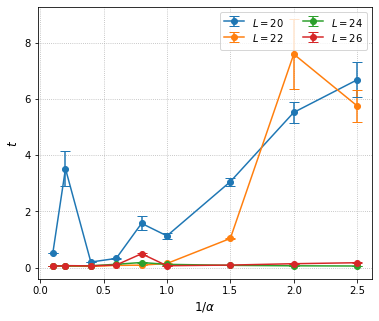

In [83]:
alpha_list = np.array([2./5., 1./2., 2./3., 1., 5./4., 5./3., 5./2., 5., 10.])
fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(1/alpha_list, t_dis_L[0], t_std_L[0]/np.sqrt(10000), marker = 'o', capsize= 5, label = r'$L=20$')
ax.errorbar(1/alpha_list, t_dis_L[1], t_std_L[1]/np.sqrt(10000), marker = 'o', capsize= 5, label = r'$L=22$')
ax.errorbar(1/alpha_list, t_dis_L[2], t_std_L[2]/np.sqrt(10000), marker = 'o', capsize= 5, label = r'$L=24$')
ax.errorbar(1/alpha_list, t_dis_L[3], t_std_L[3]/np.sqrt(10000), marker = 'o', capsize= 5, label = r'$L=26$')
ax.set_xlabel(r'$1/\alpha$', fontsize=12)
ax.set_ylabel(r'$ t $', fontsize=12)
ax.grid(True, ls='dotted')
ax.legend(loc='upper right', prop={'size': 10},ncol=2, handleheight=1.9, labelspacing=0.05)

#plt.savefig('Asympt_Dynamics_Power_Linv.pdf',  bbox_inches='tight', dpi=300)
plt.show()

In [41]:
np.random.seed(123456)
realizations = 1000
to = 3000
t_min = 3000
t_max = 3100
N_steps = 100
mean = 1
sector = 1
alpha_list = np.linspace(0.1,2.5,9)

t_gauss_dis_L = []
t_gauss_std_L = []

for L in np.arange(20,21,2):
    Sz = -L/2 +1 
    basisSzList = makeSzBasis(L)[sector]
    SiSj = SiSj_oper(basisSzList,L,0,1)
    Sz = np.abs(Sz)
    
    t_dis = []
    t_std_dis = []
    tic = time.perf_counter()
    for dis in alpha_list:
        dyn_magnon = []
        for i in range(realizations*10):
            Jz = np.random.normal(mean,dis,size = L)
            H = makeH(basisSzList,L,Jz,0)
            lam,eigv = np.linalg.eigh(H)
            num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
            num = np.random.randint(num)
            dyn_eigv = eigv[:,num]
            new_state = np.matmul(SiSj, dyn_eigv)
            new_state /= np.linalg.norm(new_state)
            exp_H = expm(-1.j*H*to)
            ev_state = np.matmul(exp_H,new_state)
            exp_val = np.vdot(new_state, ev_state)
            dyn_magnon.append(np.abs(exp_val)**2)
        gauss_mean_dyn = np.mean(dyn_magnon,axis=0)
        gauss_std_dyn = np.std(dyn_magnon,axis=0)
        A_std = gauss_mean_dyn + gauss_std_dyn/np.sqrt(realizations)
        #gauss_mean_dyn_list, gauss_std_dyn_list = power_SiSjevol(SiSj,basisSzList,Sz,dis,realizations,t_min,t_max,N_steps,L)
        #A_std2 = np.mean(gauss_mean_dyn_list)+np.std(gauss_mean_dyn_list)/np.sqrt(realizations)
        print('We get the value {}'.format(A_std))
        
        dt = 0.01
        t_values = []
        for i in range(realizations):
            t = 0 
            A_ampl = 1
            Jz = np.random.normal(mean,dis,size = L)
            H = makeH(basisSzList,L,Jz,0)
            lam,eigv = np.linalg.eigh(H)
            num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
            num = np.random.randint(num)
            dyn_eigv = eigv[:,num]
            new_state = np.matmul(SiSj, dyn_eigv)
            new_state /= np.linalg.norm(new_state)
            
            while (A_ampl > A_std): # and (A_ampl > A_std2)
                exp_H = expm(-1.j*H*t)
                ev_state = np.matmul(exp_H,new_state)
                A_ampl = np.vdot(new_state, ev_state)
                t+= dt
            t_values.append(t)
        t_mean = np.mean(t_values)
        t_std = np.std(t_values)
        t_dis.append(t_mean)
        t_std_dis.append(t_std)
        toc = time.perf_counter()
        print('Time to finish for L = {}: {}'.format(L,toc-tic))
    t_gauss_dis_L.append(t_dis)
    t_gauss_std_L.append(t_std_dis)

We get the value 0.3993814638078066
Time to finish for L = 20: 122.8781274310004
We get the value 0.6532405149695332
Time to finish for L = 20: 206.96120019200043
We get the value 0.7768489580324851
Time to finish for L = 20: 284.4140259720002
We get the value 0.8112335685095334
Time to finish for L = 20: 427.36839577
We get the value 0.8292895936077869
Time to finish for L = 20: 573.3683277350001
We get the value 0.83448339996301
Time to finish for L = 20: 701.5563962390002
We get the value 0.8398476006062059
Time to finish for L = 20: 860.5059643700001
We get the value 0.8417847938954551
Time to finish for L = 20: 992.5711474750001
We get the value 0.8439060648616914
Time to finish for L = 20: 1126.6446208210004


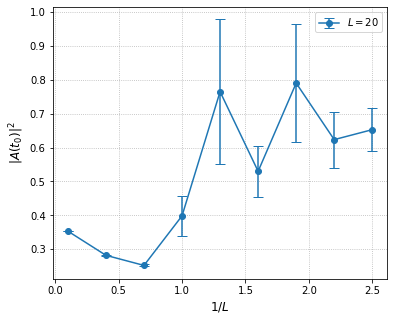

In [42]:
alpha_list = np.linspace(0.1,2.5,9)
fig, ax= plt.subplots(1,1,figsize = (6,5))

ax.errorbar(alpha_list, t_gauss_dis_L[0], t_gauss_std_L[0]/np.sqrt(1000), marker = 'o', capsize= 5, label = r'$L= 20$')
#ax.errorbar(alpha_list, t_gauss_dis_L[1], t_gauss_std_L[1]/np.sqrt(1000), marker = 'o', capsize= 5, label = r'$L= 22$')
#ax.errorbar(alpha_list, t_gauss_dis_L[2], t_gauss_std_L[2]/np.sqrt(1000), marker = 'o', capsize= 5, label = r'$L= 24$')
#ax.errorbar(alpha_list, t_gauss_dis_L[3], t_gauss_std_L[3]/np.sqrt(1000), marker = 'o', capsize= 5, label = r'$L= 26$')
ax.set_xlabel(r'$1/L$', fontsize=12)
ax.set_ylabel(r'$ |A(t_0)|^2 $', fontsize=12)
ax.grid(True, ls='dotted')
ax.legend(loc='upper right', prop={'size': 10})

#plt.savefig('Asympt_Dynamics_Power_Linv.pdf',  bbox_inches='tight', dpi=300)
plt.show()

In [40]:
t_gauss_dis_L

[[0.3533900000000002,
  0.2788400000000001,
  0.26846000000000003,
  0.46400000000001107,
  0.4669699999999991,
  0.6006000000000012,
  0.8412099999999513,
  0.8361800000000119,
  0.6310600000000129]]

In [116]:
    dyn_magnon = []
    for i in range(realizations):
        Jz = np.random.normal(mean,dis,size = L)
        H = makeH(basisSzList,L,Jz,0)
        lam,eigv = np.linalg.eigh(H)
        num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
        num = np.random.randint(num)
        dyn_eigv = eigv[:,num]
        new_state = np.matmul(SiSj, dyn_eigv)
        new_state /= np.linalg.norm(new_state)
        exp_H = expm(-1.j*H*to)
        ev_state = np.matmul(exp_H,new_state)
        exp_val = np.vdot(new_state, ev_state)
        dyn_magnon.append(np.abs(exp_val)**2)
    gauss_mean_dyn = np.mean(dyn_magnon,axis=0)
    gauss_std_dyn = np.std(dyn_magnon,axis=0)
    A_std = gauss_mean_dyn + gauss_std_dyn/np.sqrt(realizations)
    gauss_mean_dyn_list, gauss_std_dyn_list = gauss_SiSjevol(SiSj,basisSzList,Sz,mean,dis,realizations,t_min,t_max,N_steps,L)
    A_std2 = np.mean(gauss_mean_dyn_list)+np.std(gauss_mean_dyn_list)/np.sqrt(realizations)
    print('We get the values {} and {}'.format(A_std, A_std2))

We get the values 0.38894295728046696 and 0.4006824753382525


In [117]:
np.mean(gauss_mean_dyn_list)

0.400630768594807

In [19]:
np.random.seed(123456)
realizations = 1000
to = 3000
t_min = 3000
t_max = 3100
N_steps = 100
mean = 1
sector = 1
L = 20
dis = 1

Sz = -L/2 +1 
basisSzList = makeSzBasis(L)[sector]
SiSj = SiSj_oper(basisSzList,L,0,1)
Sz = np.abs(Sz)

tic = time.perf_counter()
gauss_mean_dyn_list, gauss_std_dyn_list = gauss_SiSjevol(SiSj,basisSzList,Sz,mean,dis,realizations,t_min,t_max,N_steps,L)
toc = time.perf_counter()
print('Time to finish for L = {}: {}'.format(L,toc-tic))

Time to finish for L = 20: 126.74851585299996


In [34]:
    tic = time.perf_counter()
    dyn_magnon = []
    for i in range(realizations*10):
        Jz = np.random.normal(mean,dis,size = L)
        H = makeH(basisSzList,L,Jz,0)
        lam,eigv = np.linalg.eigh(H)
        num = np.math.factorial(L/2)/(np.math.factorial(Sz)*np.math.factorial(L/2-Sz))-1
        num = np.random.randint(num)
        dyn_eigv = eigv[:,num]
        new_state = np.matmul(SiSj, dyn_eigv)
        new_state /= np.linalg.norm(new_state)
        exp_H = expm(-1.j*H*to)
        ev_state = np.matmul(exp_H,new_state)
        exp_val = np.vdot(new_state, ev_state)
        dyn_magnon.append(np.abs(exp_val)**2)
    gauss_mean_dyn = np.mean(dyn_magnon,axis=0)
    gauss_std_dyn = np.std(dyn_magnon,axis=0)
    toc = time.perf_counter()
    print('Time to finish for L = {}: {}'.format(L,toc-tic))

Time to finish for L = 20: 45.24802534799983


In [35]:
gauss_mean_dyn

0.8040074264946837

In [36]:
gauss_std_dyn

0.2997364103785051

In [22]:
np.mean(gauss_mean_dyn_list)

0.8125183939749984

In [25]:
np.std(gauss_mean_dyn_list)

0.0032610397395053743